In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import mpmath as mp

import glob

from shapely.geometry import Point, Polygon
import contextily as ctx

import preprocessing.lst_preprocessing as prep
import preprocessing.lst_grid_preprocessing as grid

# Building data
https://osmbuildings.org/ receives XYZ tiles, so we have to calculate the tiles first out of the latitude and longitude, see https://towardsdatascience.com/map-tiles-locating-areas-nested-parent-tiles-coordinates-and-bounding-boxes-e54de570d0bd for the functions

## Conversion from latitude, longitude to tiles

In [3]:
def get_tile(lat_deg, lon_deg, zoom):
    """
    A function to get the relevant tile from lat,lon,zoom)
    """   
    lat_rad = mp.radians(lat_deg)
    n = 2 ** zoom
   
    xtile = n * ((lon_deg + 180) / 360)
    ytile = float(n * (1 - (mp.log(mp.tan(lat_rad) + mp.sec(lat_rad)) / np.pi)) / 2)
    return zoom, round(xtile), round(ytile) # 'tile %d/%d/%d '%

In [4]:
def tile2lon(z,x,y):
    return x / 2**z * 360 - 180

def tile2lat(z,x,y):
    n = mp.pi - 2 * mp.pi * y / 2**z;
    return float((180 / mp.pi) * (mp.atan(0.5 * (mp.exp(n) - mp.exp(-n)))))

def tile_bbox(z,x,y):
    '''
    Returns the lat, lon bounding box of a tile
    '''
    w = tile2lon(z,x,y)
    s = tile2lat(z,x,y) 
    e = tile2lon(z,x+1,y)
    n = tile2lat(z,x,y+1)
    return [w,s,e,n]

In [5]:
get_tile(41.393, 2.1262,15)

(15, 16578, 12238)

In [6]:
get_tile(41.393, 2.1262,15)

(15, 16578, 12238)

In [7]:
tile_bbox(*get_tile(41.393, 2.1262,15))

[2.13134765625, 41.393294288784865, 2.142333984375, 41.38505194970681]

## OSMBuildings API requests

In [8]:
def osmbuildings_request(latitude:float, longitude:float):
    """
    returns json response with building data from OSMBuildings
    API for a specific latitude and longitude
    """
    
    base_url = "https://data.osmbuildings.org/0.2/anonymous/tile"
    zoom, xtile, ytile = get_tile(latitude, longitude, 15)
    
    url = f"{base_url}/{zoom}/{xtile}/{ytile}.json"
    print(f"URL: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'}
    response = requests.get(url, headers = headers)
 
    print(f"Status code: {response.status_code}")
    json_response = response.json()

    return json_response

In [9]:
json_response = osmbuildings_request(41.39907, 2.18154)

URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16583/12237.json
Status code: 200


In [10]:
json_response['features'][10]

{'id': '653644263',
 'type': 'Feature',
 'properties': {'shape': 'none', 'height': 18, 'building': '220144969'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[2.193696, 41.39337],
    [2.193713, 41.393412],
    [2.193729, 41.393411],
    [2.193742, 41.393352],
    [2.193731, 41.393344],
    [2.193721, 41.393352],
    [2.193697, 41.39333],
    [2.193686, 41.393338],
    [2.193696, 41.39337]]]}}

In [11]:
def get_building_height(json_response):
    """
    input: json response from OSM Buildings request
    output: list of building properties (height, lat, lon)
    """
    features = json_response['features']
    height = lambda elem: elem['properties']['height']
    coords = lambda elem: elem['geometry']['coordinates'][0][0]
    
    return [[height(feature), coords(feature)] for feature in features]

In [12]:
# output format height, [lat, lon]
get_building_height(json_response)

[[12, [2.18472, 41.398911]],
 [12, [2.189303, 41.399226]],
 [9, [2.197139, 41.393681]],
 [9, [2.196101, 41.393591]],
 [3, [2.197346, 41.393648]],
 [9, [2.19681, 41.393442]],
 [9, [2.196752, 41.393395]],
 [3, [2.193837, 41.394328]],
 [2.5, [2.193499, 41.393315]],
 [18, [2.193499, 41.393315]],
 [18, [2.193696, 41.39337]],
 [12, [2.193789, 41.394501]],
 [18, [2.193754, 41.393326]],
 [18, [2.193882, 41.393279]],
 [15, [2.1947, 41.393887]],
 [18, [2.193967, 41.393343]],
 [18, [2.194052, 41.393406]],
 [18, [2.193978, 41.394457]],
 [12, [2.194013, 41.39443]],
 [18, [2.194138, 41.393469]],
 [15, [2.194063, 41.394535]],
 [18, [2.194115, 41.394354]],
 [18, [2.194223, 41.393532]],
 [12, [2.194153, 41.394737]],
 [18, [2.194308, 41.393596]],
 [18, [2.194221, 41.394715]],
 [18, [2.194216, 41.394278]],
 [18, [2.194393, 41.393659]],
 [18, [2.194306, 41.394652]],
 [18, [2.194478, 41.393722]],
 [18, [2.194391, 41.394589]],
 [18, [2.194564, 41.393785]],
 [18, [2.194476, 41.394525]],
 [18, [2.194579, 41.3

## TODO:
1. align with GPS data
2. averaging procedure
3. combine with data on used area (i.e. constructed area vs natural area): e.g. https://osmlanduse.org/#15.493044589288502/2.17254/41.40487/0/, https://data.osmlanduse.org

# Land surface temperature (LST) from satellite data

Import hd5 satelite data and convert to DataFrame

## Simple testing

In [13]:
# two different L2 files containing LST
f = h5py.File('../raw_data/London/ECOSTRESS_L2_LSTE_23097_002_20220802T145219_0601_02.h5', 'r')

# L1 fille containing GPS coordinates
geo = h5py.File('../raw_data/London/ECOSTRESS_L1B_GEO_23097_002_20220802T145219_0601_01.h5', 'r')

In [14]:
def import_ECOSTRESS_data(file_path):
    return h5py.File(file_path, 'r')

In [15]:
list(import_ECOSTRESS_data('../raw_data/ECOSTRESS_L2_LSTE_22928_003_20220722T171854_0601_01.h5').keys())

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../raw_data/ECOSTRESS_L2_LSTE_22928_003_20220722T171854_0601_01.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
list(geo.keys())

['Geolocation', 'L1GEOMetadata', 'StandardMetadata']

In [ ]:
np.array(geo['Geolocation']['height'])

array([[ 49.432453,  49.434498,  49.436543, ..., 140.57167 , 161.01259 ,
        196.6524  ],
       [ 49.430782,  49.432823,  49.434868, ..., 151.71326 , 176.12303 ,
        202.03879 ],
       [ 49.429108,  49.43115 ,  49.433193, ..., 149.21332 , 172.03925 ,
        186.2959  ],
       ...,
       [ 46.972557,  46.974464,  46.976368, ..., 547.01306 , 555.8041  ,
        550.8056  ],
       [ 46.972878,  46.97478 ,  46.976685, ..., 542.969   , 548.04517 ,
        554.00757 ],
       [ 46.97319 ,  46.975094,  46.976997, ..., 529.60706 , 546.77094 ,
        554.7777  ]], dtype=float32)

In [ ]:
# acess LST
lst = f['SDS']['LST']
lst2 = f2['SDS']['LST']

# access latitude and longitude
lat, lon = geo['Geolocation']['latitude'], geo['Geolocation']['longitude']

In [ ]:
np.array(lst)[100:110,100:110]

array([[15053, 15096, 15054, 15075, 15074, 15092, 15077, 15097, 15081,
        15064],
       [15063, 15093, 15060, 15070, 15066, 15093, 15080, 15100, 15073,
        15070],
       [15072, 15081, 15072, 15081, 15054, 15094, 15090, 15090, 15074,
        15071],
       [15079, 15075, 15077, 15080, 15069, 15088, 15081, 15081, 15076,
        15070],
       [15084, 15078, 15080, 15076, 15084, 15083, 15070, 15079, 15075,
        15084],
       [15082, 15087, 15067, 15078, 15085, 15076, 15076, 15078, 15079,
        15084],
       [15074, 15091, 15070, 15078, 15088, 15077, 15079, 15079, 15093,
        15080],
       [15072, 15089, 15080, 15081, 15083, 15092, 15084, 15092, 15090,
        15088],
       [15072, 15094, 15074, 15077, 15073, 15102, 15081, 15101, 15081,
        15088],
       [15075, 15092, 15075, 15073, 15074, 15100, 15083, 15097, 15080,
        15084]], dtype=uint16)

In [ ]:
# flatten for DataFrame
lst_flat = np.array(lst).reshape(1, 5632*5400)
lat_flat = np.array(lat).reshape(1, 5632*5400)
lon_flat = np.array(lon).reshape(1, 5632*5400)

In [ ]:
# convert to Dataframe
lst_df = pd.DataFrame({'LST': lst_flat[0],
                      'Lat': lat_flat[0], 
                      'Lon': lon_flat[0]})
lst_df.sample(10)

,LST,Lat,Lon
2748553,14521,43.512153,-1.443059
28904293,15351,44.005784,2.844377
12774864,14904,43.244933,0.674730
7085441,15088,41.165680,1.736955
20492851,0,44.538082,0.746286
104684,15037,41.535480,0.139643
17290875,15086,41.404988,3.263909
24104551,15267,44.203406,1.772611
20094580,14998,42.239792,2.969658
9366396,14955,42.475351,0.855008


In [ ]:
def construct_polygon(position):
    """
    creates shapely Polygon from lat, lon
    """
    
    return Polygon(position)

In [ ]:
def get_position(lat, lon, i, j):
    """
    returns single list of 4 corners as position 
    for construct_polygon input
    """
    position = ([lon[i][j],lat[i][j]],\
                [lon[i][j+1],lat[i][j+1]],\
                [lon[i+1][j+1],lat[i+1][j+1]],\
                [lon[i+1][j],lat[i+1][j]])
    
    return position

In [ ]:
def convert2df(lst_data, lat_data, lon_data, x_lim, y_lim):
    """
    converts input data: LST, Latitude, Longitude in hd5 format with specified
    indeces in lat, lon 
    data to GeoPandas DataFrame
    """
    # access LST, multiply by 0.02 scale factor 
    # see https://ecostress.jpl.nasa.gov/downloads/psd/ECOSTRESS_SDS_PSD_L2_ver1-1.pdf
    # convert to celcius
    
    SCALE_FACTOR = 0.02
    KELVIN_CELCIUS = -273.15
    
    lst = (SCALE_FACTOR * np.array(lst_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]) + KELVIN_CELCIUS
    
    # acess latitude and longitude
    lat = np.array(lat_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]
    lon = np.array(lon_data)[x_lim[0]:x_lim[1], y_lim[0]:y_lim[1]]
    
    print(lat.shape, lat[0])

    # flatten for DataFrame
    lst_flat = lst.reshape(1, np.multiply(*lst.shape))
    lat_flat = lat.reshape(1, np.multiply(*lat.shape))
    lon_flat = lon.reshape(1, np.multiply(*lon.shape))
    
    # convert to Dataframe
    lst_df = pd.DataFrame({'LST': lst_flat[0],
                        'Lat': lat_flat[0], 
                        'Lon': lon_flat[0]})
    
    # create polygons for 70x70 m² tiles
    x_range = range(0,lon.shape[0]-1)
    y_range = range(0,lat.shape[1]-1)
    
    polygons = [construct_polygon(get_position(lat, lon, i, j)) for i in x_range for j in y_range]
   
    
    # convert to GeoPandas DataFrame
    # lst_df.iloc[:len(polygons),:] since polygons need on corner further
    gdf = geopandas.GeoDataFrame(lst_df.iloc[:len(polygons),:], geometry=polygons)#, crs = "EPSG:4326")
        
    return gdf

In [ ]:
gdf_small = convert2df(lst,lat, lon, [1000,1020], [2000,2020])
gdf_small

(20, 20) [41.82422548 41.8247524  41.82528066 41.82579168 41.82633958 41.82684542
 41.82737921 41.8279215  41.82849343 41.82907114 41.8296134  41.83010326
 41.83062558 41.83114925 41.83168924 41.83222709 41.83272269 41.83323546
 41.83375372 41.83426341]


,LST,Lat,Lon,geometry
0,26.79,41.824225,0.809180,"POLYGON ((0.80918 41.82423, 0.80865 41.82475, ..."
1,26.65,41.824752,0.808650,"POLYGON ((0.80865 41.82475, 0.80812 41.82528, ..."
2,26.99,41.825281,0.808120,"POLYGON ((0.80812 41.82528, 0.80761 41.82579, ..."
3,26.75,41.825792,0.807613,"POLYGON ((0.80761 41.82579, 0.80706 41.82634, ..."
4,27.03,41.826340,0.807060,"POLYGON ((0.80706 41.82634, 0.80655 41.82685, ..."
...,...,...,...,...
356,26.97,41.839814,0.813559,"POLYGON ((0.81535 41.83921, 0.81482 41.83974, ..."
357,26.87,41.840344,0.813030,"POLYGON ((0.81482 41.83974, 0.81431 41.84024, ..."
358,26.89,41.840869,0.812499,"POLYGON ((0.81431 41.84024, 0.81378 41.84076, ..."
359,26.83,41.841376,0.811992,"POLYGON ((0.81378 41.84076, 0.81325 41.84129, ..."


## With functions from preprocessing.lst_preprocessing

In [16]:
 city_name = "London"
 df = prep.convert2df_coord(*prep.import_city_data(city_name),*prep.CITY_BOUNDING_BOXES[city_name])
 df.head(10)

,LST,Latitude,Longitude,height,LST_Difference,height_Difference
0,17.230011,51.469460,-0.215520,54.856796,-7.661585,-66.131149
1,17.989990,51.470215,-0.215993,58.094570,-6.901606,-62.893375
2,16.630005,51.469730,-0.214343,48.727318,-8.261591,-72.260628
3,17.750000,51.470474,-0.214803,54.617947,-7.141596,-66.369995
4,18.489990,51.471260,-0.215315,49.401390,-6.401606,-71.586555
5,20.109985,51.472015,-0.215786,52.828224,-4.781610,-68.159721
6,21.750000,51.472778,-0.216270,53.543209,-3.141596,-67.444733
7,16.609985,51.469227,-0.212649,53.278511,-8.281610,-67.709435
8,16.850006,51.469959,-0.213114,53.670322,-8.041590,-67.317627
9,17.790009,51.470726,-0.213600,53.753899,-7.101587,-67.234047


In [17]:
df_London = pd.read_csv('../processed_data/London.csv')
df_London.head(10)

,LST,Latitude,Longitude,height,LST_Difference,height_Difference
0,17.23,51.469460,-0.215520,54.856796,-11.087025,-66.145340
1,17.99,51.470214,-0.215993,58.094570,-10.327025,-62.907566
2,16.63,51.469732,-0.214343,48.727318,-11.687025,-72.274818
3,17.75,51.470475,-0.214803,54.617947,-10.567025,-66.384186
4,18.49,51.471262,-0.215315,49.401390,-9.827025,-71.600746
5,20.11,51.472015,-0.215786,52.828224,-8.207025,-68.173912
6,21.75,51.472779,-0.216270,53.543209,-6.567025,-67.458923
7,16.61,51.469227,-0.212649,53.278511,-11.707025,-67.723625
8,16.85,51.469959,-0.213114,53.670322,-11.467025,-67.331818
9,17.79,51.470725,-0.213600,53.753899,-10.527025,-67.248238


## Resample swath to grid

In [ ]:
# ! pip install pyresample

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached PyYAML-6.0-cp310-cp310-macosx_10_9_x86_64.whl (197 kB)
  DEPRECATION: configobj is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for configobj ... done


In [ ]:
from pyresample import geometry as geom
from pyresample import kd_tree as kdt
import pyproj

In [18]:
lst_data, lat_data, lon_data, height_data = prep.import_city_data('Paris')
lat_data.shape

(5632, 5400)

In [ ]:
def swath_to_grid(lst_data: np.array, 
                  lon_data: np.array,
                  lat_data: np.array):#,height_data :np.array):
    """
    converts satellite swath to regular grid
    based upon: https://git.earthdata.nasa.gov/projects/LPDUR/repos/tutorial-ecostress/browse/ECOSTRESS_Tutorial.ipynb
    """
    # pixel size
    PIXEL_SIZE = 70
    
    # Set swath definition from lat/lon arrays
    swath_def= geom.SwathDefinition(lons=lon_data, lats=lat_data)
   
    #Define the coordinates in the middle of the swath, which are used 
    # to calculate an estimate of the output rows/columns for the gridded output.
    mid = [int(lat_data.shape[1] / 2) - 1, int(lat_data.shape[0] / 2) - 1]
    mid_lat, mid_lon = lat_data[mid[0]][mid[1]], lon_data[mid[0]][mid[1]]

    # Define AEQD projection centered at swath center
    epsg_convert = pyproj.Proj("+proj=aeqd +lat_0={} +lon_0={}".format(mid_lat, mid_lon))

    # Use info from AEQD projection bbox to calculate output cols/rows/pixel size
    ll_lon, ll_lat = epsg_convert(np.min(lon_data), np.min(lat_data), inverse=False)
    ur_lon, ur_lat = epsg_convert(np.max(lon_data), np.max(lat_data), inverse=False)
    area_extent = (ll_lon, ll_lat, ur_lon, ur_lat)
    
    cols = int(round((area_extent[2] - area_extent[0]) / PIXEL_SIZE))  # 70 m pixel size
    rows = int(round((area_extent[3] - area_extent[1]) / PIXEL_SIZE)) 
    
    #Use number of rows and columns generated above from the AEQD projection
    # to set a representative number of rows and columns in the Geographic area definition, 
    # which will then be translated to degrees below, then take the smaller
    # of the two pixel dims to determine output size and ensure square pixels.

    # Define Geographic projection
    epsg, proj, proj_name = '4326', 'longlat', 'Geographic'

    # Define bounding box of swath
    ll_lon, ll_lat, ur_lon, ur_lat = np.min(lon_data), np.min(lat_data), np.max(lon_data), np.max(lat_data)
    area_extent = (ll_lon, ll_lat, ur_lon, ur_lat)

    # Create area definition with estimated number of columns and rows
    proj_dict = pyproj.CRS("epsg:4326")
    area_def = geom.AreaDefinition(epsg, proj_name, proj, proj_dict, cols, rows, area_extent)
    
    # Square pixels and calculate output cols/rows
    pixel_size = np.min([area_def.pixel_size_x, area_def.pixel_size_y])
    cols = int(round((area_extent[2] - area_extent[0]) / pixel_size))
    rows = int(round((area_extent[3] - area_extent[1]) / pixel_size))

    # Set up a new Geographic area definition with the refined cols/rows
    area_def = geom.AreaDefinition(epsg, proj_name, proj, proj_dict, cols, rows, area_extent)
    
    # Get arrays with information about the nearest neighbor to each grid point
    # function is comparing the swath and area definitions 
    # to locate the nearest neighbor (neighbours=1). 
    # 210 is the radius_of_influence, or the radius used to search for the nearest 
    # neighboring pixel in the swath (in meters).
    index, outdex, index_array, dist_array = kdt.get_neighbour_info(swath_def, area_def, 210, neighbours=1)
    
 
    # The second step is to use those arrays to retrieve a resampled result.
    # Perform K-D Tree nearest neighbor resampling (swath 2 grid conversion)
    lst_grid = kdt.get_sample_from_neighbour_info('nn', area_def.shape, lst_data, index,\
                                                  outdex, index_array, fill_value=0)
    
    # ToDo: height_data 
    
    # Define the geotransform: lower_left latitude, longitude, pixel_size
    geo_transform = [area_def.area_extent[0], area_def.area_extent[1], pixel_size]
    
    return lst_grid, geo_transform

In [ ]:
lst_gridded = swath_to_grid(lst_data, lon_data, lat_data)

In [ ]:
lst_gridded[1]

[-3.0244005, 47.516933, 0.0006295662363529403]

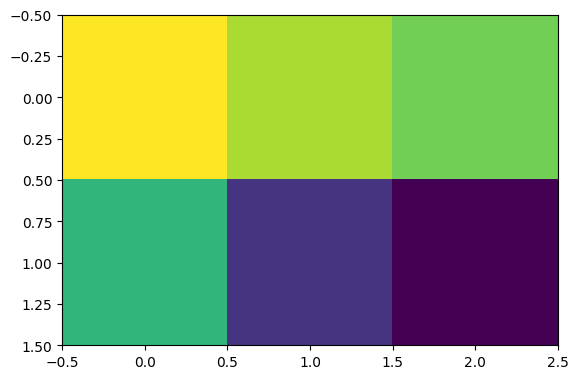

In [71]:
plt.imshow(lst_gridded[0][5000:5002,7000:7003])

In [21]:
def get_pixel_coords(row_col: list, geo_transform: list) -> list:
    """
    returs list of corner coordinates lat, lon of pixel 
    for specific row and column
    format: [upper_left, lower_left, lower_right, upper_right]
    """
    pixel_size = geo_transform[-1]
    row = row_col[0]
    col = row_col[1]
    
    current_row = geo_transform[1] + pixel_size * (row - 1)
    next_row = current_row + pixel_size
    
    current_col = geo_transform[0] + pixel_size * (col - 1)
    next_col = current_col + pixel_size
    
    upper_left = [current_row, current_col]
    lower_left = [next_row, current_col]
    lower_right = [next_row, next_col]
    upper_right = [current_row, next_col]
  
    return [upper_left, lower_left, lower_right, upper_right]

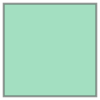

In [ ]:
Polygon(get_pixel_coords((0,2),geo_transform=lst_gridded[1]))

In [ ]:
get_pixel_coords_vec = np.vectorize(get_pixel_coords)

In [22]:
get_pixel_coords((3,2),geo_transform=lst_gridded[1])

[[47.51819257363481, -3.0237709064046383],
 [47.51882213987117, -3.0237709064046383],
 [47.51882213987117, -3.0231413401682854],
 [47.51819257363481, -3.0231413401682854]]

In [25]:
lst_gridded[1]

[-3.0244005, 47.516933, 0.0006295662363529403]

In [60]:
def coord_bounds_to_pixels(geo_transform, bounds):
    """
    converts coordinate bounds in lon, lat format
    to pixel bounds in lon, lat format
    """
    pixel_size = geo_transform[-1]
    
    lon_start = round((bounds[0][0]-geo_transform[0])/pixel_size)
    lon_end = round((bounds[0][1]-geo_transform[0])/pixel_size)

    lat_start = round((bounds[1][0]-geo_transform[1])/pixel_size)
    lat_end = round((bounds[1][1]-geo_transform[1])/pixel_size)

    return lon_start,lon_end + 1, lat_start, lat_end + 1

In [61]:
coord_bounds_to_pixels(lst_gridded[1], prep.CITY_BOUNDING_BOXES['Paris'])

(8400, 8652, 2060, 2199)

In [67]:
lst_gridded[0][2060:2199, 8400:8652].shape

(139, 252)

In [128]:
def build_gdf(lst_data_grid, geo_transform, city):
    """
    build GeoDataFrame
    """
    
    # pixel bounds
    lon_bounds = coord_bounds_to_pixels(geo_transform, prep.CITY_BOUNDING_BOXES[city])[:2]
    lat_bounds = coord_bounds_to_pixels(geo_transform, prep.CITY_BOUNDING_BOXES[city])[2:]
    
    # pixel ranges
    lon_range = np.arange(*lon_bounds)
    lat_range = np.arange(*lat_bounds)
    
    # slice data
    lst_slice = lst_data_grid[lat_bounds[0]:lat_bounds[1], lon_bounds[0]:lon_bounds[1]]
    # height data
    
    # corner coordinates
    corners = np.array([[get_pixel_coords((row, col), geo_transform) \
        for col in lon_range] for row in lat_range])
    
    # flatten
    lst_flat = lst_slice.reshape(np.multiply(*lst_slice.shape), )
    corners_flat = corners.reshape(np.multiply(*corners.shape[:2]),*corners.shape[2:])

    # build shapely polygons
    polygons = [Polygon(single_corners) for single_corners in corners_flat]
    
    # GeoDataFrame
    gpd = geopandas.GeoDataFrame(lst_flat.T, geometry = polygons)
    gpd.columns = ['LST', 'geometry']
    
    return gpd

In [129]:
build_gdf(lst_gridded[0], lst_gridded[1], "London")

,LST,geometry
0,15082.0,"POLYGON ((48.81321 2.26333, 48.81384 2.26333, ..."
1,15085.0,"POLYGON ((48.81321 2.26396, 48.81384 2.26396, ..."
2,15080.0,"POLYGON ((48.81321 2.26459, 48.81384 2.26459, ..."
3,15119.0,"POLYGON ((48.81321 2.26522, 48.81384 2.26522, ..."
4,15052.0,"POLYGON ((48.81321 2.26584, 48.81384 2.26584, ..."
...,...,...
35023,15365.0,"POLYGON ((48.90009 2.41883, 48.90072 2.41883, ..."
35024,15345.0,"POLYGON ((48.90009 2.41946, 48.90072 2.41946, ..."
35025,15345.0,"POLYGON ((48.90009 2.42009, 48.90072 2.42009, ..."
35026,15292.0,"POLYGON ((48.90009 2.42072, 48.90072 2.42072, ..."


In [52]:
lon_range = np.arange(*get_specfic_tile(lst_gridded[1], prep.CITY_BOUNDING_BOXES['Paris'])[:2])
lat_range = np.arange(*get_specfic_tile(lst_gridded[1], prep.CITY_BOUNDING_BOXES['Paris'])[2:])

In [130]:
grid.build_gdf("Paris")

,LST,geometry
0,15082.0,"POLYGON ((48.81321 2.26333, 48.81384 2.26333, ..."
1,15085.0,"POLYGON ((48.81321 2.26396, 48.81384 2.26396, ..."
2,15080.0,"POLYGON ((48.81321 2.26459, 48.81384 2.26459, ..."
3,15119.0,"POLYGON ((48.81321 2.26522, 48.81384 2.26522, ..."
4,15052.0,"POLYGON ((48.81321 2.26584, 48.81384 2.26584, ..."
...,...,...
35023,15365.0,"POLYGON ((48.90009 2.41883, 48.90072 2.41883, ..."
35024,15345.0,"POLYGON ((48.90009 2.41946, 48.90072 2.41946, ..."
35025,15345.0,"POLYGON ((48.90009 2.42009, 48.90072 2.42009, ..."
35026,15292.0,"POLYGON ((48.90009 2.42072, 48.90072 2.42072, ..."


In [72]:
corners = [[get_pixel_coords((row, col),geo_transform=lst_gridded[1]) for col in lon_range] for row in lat_range]

In [73]:
np.array(corners).shape

(139, 252, 4, 2)

In [19]:
lst_data, lat_data, lon_data, height_data = prep.import_city_data('Paris')
lst_gridded = grid.swath_to_grid(lst_data, lon_data, lat_data)

In [ ]:
size_array = np.array([[(row, col) for col in np.arange(lst_gridded[0].shape[1])] for row in np.arange(lst_gridded[0].shape[0])],dtype= np.uint16)

In [ ]:
lst_gridded[1]

[-3.0244005, 47.516933, 0.0006295662363529403]

In [ ]:
lst_gridded[0].shape

(7241, 10928)

In [ ]:
coords = [get_pixel_coords([i,j], lst_gridded[1]) for i in range(1000) for j in range(500)]

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [ ]:
get_pixel_coords_vec(size_array[0][:10], geo_transform = lst_gridded[1])

IndexError: invalid index to scalar variable.

In [ ]:
[[get_pixel_coords(row, col, geo_transform=lst_gridded[1])] for row in range(lst_gridded[0].shape[0]) for col in range(lst_gridded[0].shape[1])]

In [ ]:
lst_gridded[0].shape

(7241, 10928)

## Getting correct bounding box coordinates

In [ ]:
df_London = pd.read_csv('../processed_data/London.csv')
df_London.sample(10)

NameError: name 'pd' is not defined

In [ ]:
# smth is odd with the LST and the distance to the mean values
np.average(df_London.LST), np.average(df_London.LST_Difference), np.average(df_London.height), np.average(df_London.height_Difference)

(15.214031771442674,
 -13.102993553420587,
 69.16656817618309,
 -51.83556803220687)

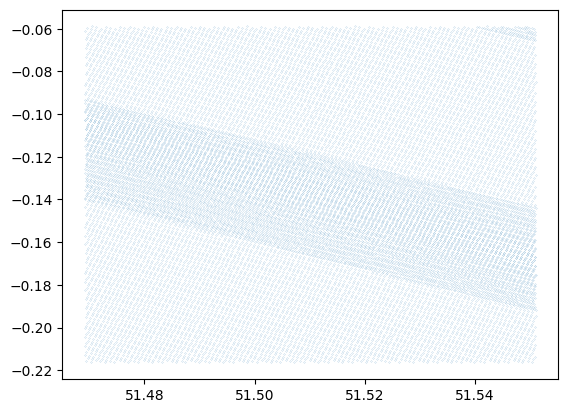

In [ ]:
plt.scatter(df_London['Latitude'], df_London['Longitude'], s=0.01)

In [ ]:
import matplotlib.cm as cm

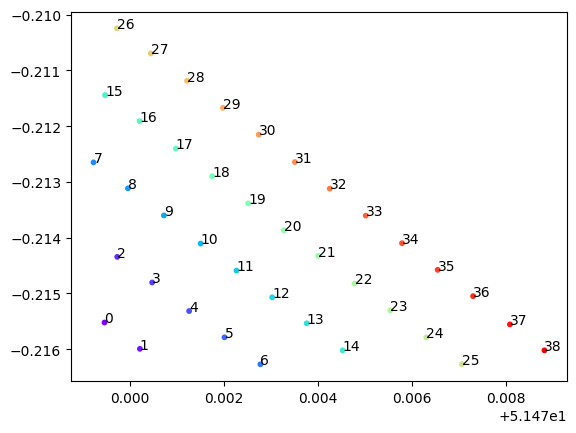

In [ ]:
number_points = 39

colors = cm.rainbow(np.linspace(0, 1, number_points))
lat_x = df_London['Latitude'][:number_points]
lon_x = df_London['Longitude'][:number_points]

fig, ax = plt.subplots()

ax.scatter(lat_x, lon_x, s=10, c = colors)
for i in range(number_points):
    ax.annotate(i, (lat_x[i], lon_x[i]))

In [ ]:
def get_closest_point(latitude: float, lat_data: pd.DataFrame):
    """
    returns closest latitude inside lat_data for 
    initial latitude point
    """
    
    
    

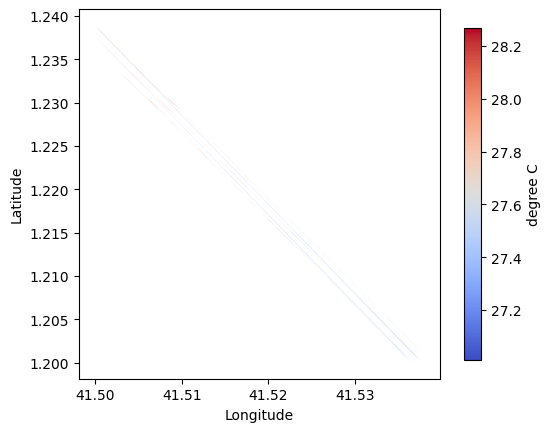

In [ ]:
gdf_coord.loc[1000:1200,:].plot(column = 'LST', cmap = 'coolwarm', legend=True, legend_kwds={'shrink': 0.9, 'label': 'degree C'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

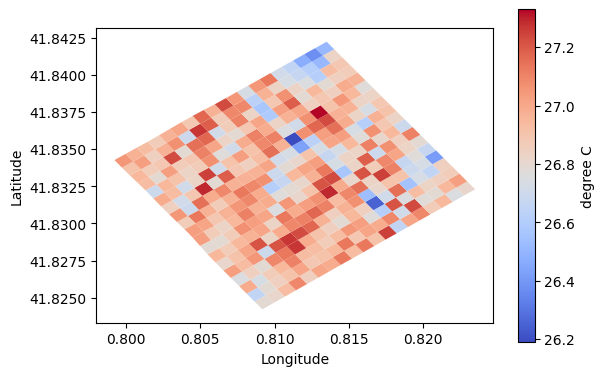

In [ ]:
gdf_small.plot(column = 'LST', cmap = 'coolwarm', legend=True, legend_kwds={'shrink': 0.9, 'label': 'degree C'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

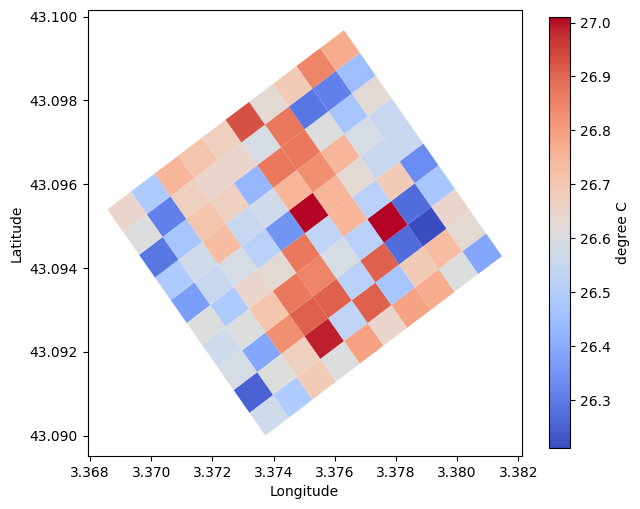

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

convert2df(lst,lat, lon, [5000,5011],[2000,2011]).plot(column = 'LST', cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.8, 'label': 'degree C'},ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

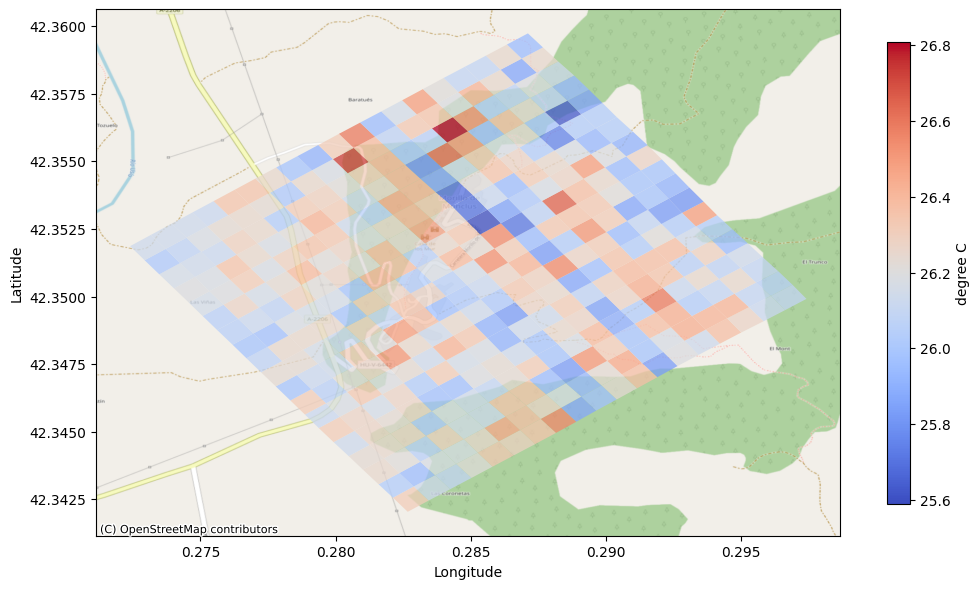

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
convert2df(lst,lat, lon, [1000,1020], [3000,3020]).plot(column = 'LST', cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.5, 'label': 'degree C'},alpha = .75, ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

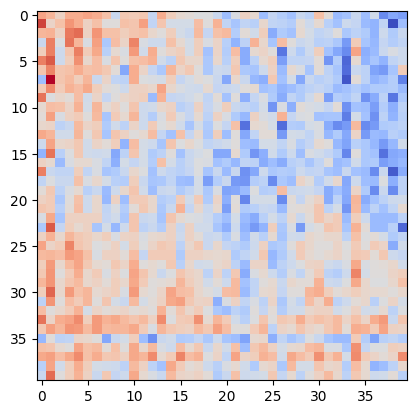

In [ ]:
# sample plot
plt.imshow(np.array(lst)[2000:2040,2000:2040], cmap = 'coolwarm')

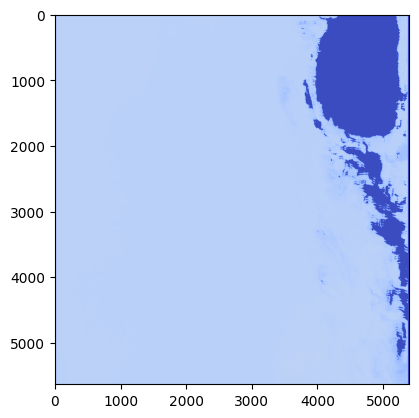

In [ ]:
plt.imshow(np.array(lst), cmap = 'coolwarm')

## TODO:
1. align with GPS data
2. plotting on map
3. averaging procedure?

# Further geographical-building data: Ohsome API
Docu: https://docs.ohsome.org/ohsome-api/v1/index.html <br>
Examples: https://docs.ohsome.org/ohsome-api/v1/filter.html#examples

In [ ]:
# total area
URL = 'https://api.ohsome.org/v1/elements/area'
data = {"bboxes": "8.625,49.3711,8.7334,49.4397", "format": "json", "time": "2014-01-01", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2014-01-01T00:00:00Z', 'value': 10242756.68}]}


In [ ]:
# density
URL = 'https://api.ohsome.org/v1/elements/count/density'
data = {"bboxes": "8.625,49.3711,8.7334,49.4397", "format": "json", "time": "2019-05-07", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2019-05-07T00:00:00Z', 'value': 5.9}]}


In [ ]:
# 41.4043, 2.18345, 41.40426, 2.18776
data = {"bboxes": "2.18345,41.4043,2.18776,41.40426", "format": "json", "time": "2019-05-07", "filter": "landuse=residential"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'result': [{'timestamp': '2019-05-07T00:00:00Z', 'value': 0.0}]}


In [ ]:
# geometry
URL = 'https://api.ohsome.org/v1/contributions/geometry'
data = {"bboxes": "8.6720,49.3988,8.7026,49.4274", "time": "2020-02-01,2020-06-29", "filter": "landuse=farmland"}
response = requests.post(URL, data=data)
print(response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.8.0', 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[8.6768983, 49.4251524], [8.6772148, 49.4246729], [8.6771852, 49.4246671], [8.6766461, 49.4245684], [8.6765662, 49.4247096], [8.675516, 49.4245251], [8.6754856, 49.4245859], [8.6757673, 49.4248258], [8.675901, 49.4249687], [8.6768983, 49.4251524]]]}, 'properties': {'@contributionChangesetId': 86062107, '@osmId': 'way/283940872', '@timestamp': '2020-06-01T20:08:25Z'}}]}


# Elevation data

From: https://api.open-elevation.com/

In [ ]:
base_url = "https://api.open-elevation.com/api/v1/lookup?locations"
coords = [41.161758,-8.583933] #lat, lon
params = {'locations':','.join([str(i) for i in coords])}

response = requests.get(base_url, params=params)
print(f'status: {response.status_code}')
print(f'url: {response.url}')
response.json()

status: 200
url: https://api.open-elevation.com/api/v1/lookup?locations&locations=41.161758%2C-8.583933


{'results': [{'latitude': 41.161758,
   'longitude': -8.583933,
   'elevation': 117}]}

# Further testing

In [ ]:
lst_df_short = lst_df.loc[2000:4000,:]

In [ ]:
gdf = geopandas.GeoDataFrame(
    lst_df_short, geometry=geopandas.points_from_xy(lst_df_short.Lon, lst_df_short.Lat))

gdf.head(7)

,LST,Lat,Lon,geometry
2000,15036,41.483136,0.170243,POINT (0.17024 41.48314)
2001,15031,41.483658,0.169708,POINT (0.16971 41.48366)
2002,15027,41.484182,0.169174,POINT (0.16917 41.48418)
2003,15031,41.484685,0.168663,POINT (0.16866 41.48468)
2004,15031,41.485228,0.168105,POINT (0.16810 41.48523)
2005,15029,41.485730,0.167593,POINT (0.16759 41.48573)
2006,15038,41.486246,0.167056,POINT (0.16706 41.48625)


In [ ]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

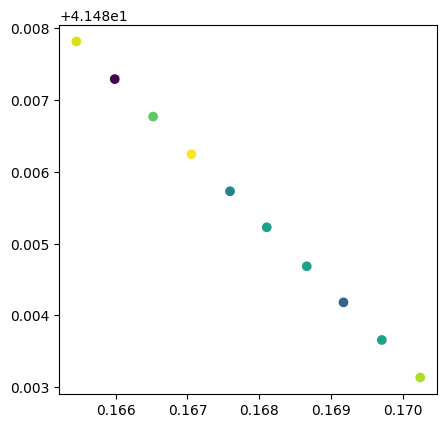

In [ ]:
gdf.iloc[:10,:].plot(column = 'LST', k=9)

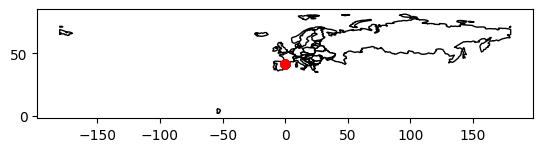

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
import shapely

In [ ]:
# couldn't find belgrade geometry, used osmnx and simplified geometry as a WKT string
belgrade_poly = shapely.wkt.loads(
    "POLYGON ((20.2213764 44.9154621, 20.2252450 44.9070062, 20.2399466 44.9067193, 20.2525385 44.8939145, 20.2419942 44.8842235, 20.2610016 44.8826597, 20.2794675 44.8754192, 20.2858284 44.8447802, 20.2856918 44.8332410, 20.3257447 44.8342507, 20.3328068 44.8098272, 20.3367239 44.8080890, 20.3339619 44.8058144, 20.3353253 44.8011005, 20.3336310 44.8003791, 20.3360230 44.7898245, 20.3384687 44.7907875, 20.3405086 44.7859144, 20.3417344 44.7872272, 20.3474466 44.7713203, 20.3509860 44.7687822, 20.3398029 44.7558716, 20.3220093 44.7448572, 20.3160895 44.7387338, 20.3235092 44.7345531, 20.3359605 44.7308053, 20.3437350 44.7301552, 20.3450306 44.7243651, 20.3497410 44.7209764, 20.3521450 44.7143627, 20.3633795 44.7046060, 20.3830709 44.7030441, 20.3845248 44.7011631, 20.3847991 44.7032182, 20.3924066 44.7036702, 20.4038881 44.6984458, 20.4097684 44.6992834, 20.4129839 44.7024603, 20.4192098 44.7021308, 20.4217436 44.7034920, 20.4251744 44.6976337, 20.4279418 44.6980838, 20.4313251 44.6940680, 20.4358368 44.6933579, 20.4402665 44.6905161, 20.4452138 44.6910160, 20.4495428 44.6880459, 20.4539572 44.6888231, 20.4529809 44.6911331, 20.4550753 44.6919188, 20.4534174 44.6929137, 20.4571253 44.6957696, 20.4570013 44.7008391, 20.4614601 44.7027894, 20.4646634 44.7018970, 20.4674388 44.7050131, 20.4753542 44.7039532, 20.4760757 44.7050260, 20.4802055 44.7033479, 20.4867635 44.7061539, 20.4983359 44.7022445, 20.5049892 44.7021663, 20.5071809 44.7071295, 20.5027682 44.7154832, 20.5028502 44.7217294, 20.5001912 44.7225288, 20.5007294 44.7251513, 20.5093727 44.7271542, 20.5316662 44.7248060, 20.5385861 44.7270519, 20.5390058 44.7329843, 20.5483761 44.7280993, 20.5513810 44.7308508, 20.5510751 44.7340860, 20.5483958 44.7345580, 20.5503614 44.7352316, 20.5509440 44.7434333, 20.5416617 44.7521169, 20.5358563 44.7553171, 20.5348919 44.7609694, 20.5393015 44.7624855, 20.5449353 44.7698750, 20.5490005 44.7708792, 20.5488362 44.7733456, 20.5647717 44.7649237, 20.5711431 44.7707818, 20.5772388 44.7711074, 20.5798915 44.7727751, 20.5852472 44.7808647, 20.5817268 44.7826053, 20.5823183 44.7845765, 20.5792147 44.7843299, 20.5777701 44.7872565, 20.5744279 44.7854098, 20.5740215 44.7886805, 20.5693220 44.7911579, 20.5655386 44.7906451, 20.5635444 44.7921747, 20.5598333 44.7901679, 20.5536143 44.7898282, 20.5502434 44.7909478, 20.5435002 44.8022967, 20.5424780 44.8073064, 20.5474459 44.8103678, 20.5530335 44.8102412, 20.5652728 44.8188428, 20.5738545 44.8279189, 20.5724006 44.8315147, 20.5776931 44.8371416, 20.5765153 44.8378971, 20.5863097 44.8427122, 20.5826128 44.8462544, 20.5762290 44.8486489, 20.5825139 44.8520894, 20.5953933 44.8552493, 20.6206689 44.8543410, 20.6212821 44.8560293, 20.6173687 44.8574761, 20.5961883 44.8615803, 20.5928447 44.8609861, 20.5911876 44.8626994, 20.6019440 44.8670619, 20.6196285 44.8673213, 20.6232109 44.8693710, 20.6164092 44.8815202, 20.6152606 44.8895682, 20.5777643 44.8860527, 20.5311826 44.8712209, 20.5230234 44.8646244, 20.5226088 44.8685278, 20.5187616 44.8654899, 20.5197414 44.8694015, 20.5132944 44.8687179, 20.5076686 44.8735038, 20.5065584 44.8670548, 20.4991594 44.8719635, 20.4938631 44.8734651, 20.4821047 44.8723679, 20.4737899 44.8677144, 20.4661802 44.8592493, 20.4594505 44.8560945, 20.4600397 44.8546034, 20.4650988 44.8535738, 20.4600110 44.8491680, 20.4623204 44.8477906, 20.4603705 44.8445375, 20.4711373 44.8342913, 20.4706338 44.8317839, 20.4498025 44.8343946, 20.4244846 44.8431449, 20.4138827 44.8526577, 20.3912248 44.8598333, 20.3749815 44.8683583, 20.3617778 44.8791076, 20.3436922 44.9103973, 20.3390650 44.9117584, 20.3011288 44.9426876, 20.2946156 44.9402419, 20.2960052 44.9381397, 20.2746476 44.9304194, 20.2703905 44.9345682, 20.2213764 44.9154621))"
)
# plot belgrade city limits
m = gpd.GeoDataFrame(geometry=[belgrade_poly], crs="epsg:4326").explore(name="Belgrade", height=300, width=500)
# plot the points, just for demo purposes plot outcomes as different colors
m = geo_df.explore(m=m, column="Outcome", cmap=["red","green","blue"], name="points")
# add layer control so layers can be switched on / off
folium.LayerControl().add_to(m)

m

In [ ]:
from shapely.geometry import Point, Polygon

In [ ]:
polygons = Polygon(list(zip(lst_df_short.Lat,lst_df_short.Lon)))
polygons[0]

TypeError: 'Polygon' object is not subscriptable

In [ ]:
lst_geo = geopandas.GeoDataFrame(lst_df_short, geometry=polygons)

InvalidIndexError: POLYGON ((41.48313557209461 0.1702429396412618, 41.48365802301039 0.1697081809130573, 41.484181900540754 0.1691740366226686, 41.48468465587471 0.1686625316548557, 41.4852275608904 0.168104901652531, 41.485729683417986 0.1675931543834063, 41.48624621264621 0.1670559243334981, 41.48677000189317 0.1665218041319669, 41.48729244000919 0.1659871238267819, 41.48781649084728 0.1654531440617752, 41.48834568984518 0.1649214056804491, 41.48884955638144 0.1644104957446461, 41.489368945344516 0.1638745426680638, 41.489896413783114 0.1633421163391749, 41.490421755199044 0.162808783792287, 41.49094811240482 0.1622759152509411, 41.491456148383755 0.1617669260624553, 41.49198491448283 0.1612351715332174, 41.492514976681505 0.1607040110165902, 41.493034643191926 0.1602002620759434, 41.49361111290057 0.1596577911917708, 41.49414988300752 0.1591306488496558, 41.49465274680113 0.1586195733887569, 41.49517600336221 0.1580855629830953, 41.49567339574343 0.1575399408628974, 41.49616647681643 0.1569923249288608, 41.49668030578486 0.1564540313079492, 41.497174868358115 0.1559391915759544, 41.49771481071833 0.1553805144234563, 41.49823427203783 0.1548447608327203, 41.49873612648957 0.1543332478008788, 41.49926870813851 0.1538035195030806, 41.49979461174598 0.1532707603029196, 41.500318946089116 0.1527372987346788, 41.50084640169273 0.1522052958833532, 41.50137288051017 0.1516728712439493, 41.50187365610427 0.1511609646982771, 41.502397380662465 0.1506272898852613, 41.50290148289202 0.1501169610863643, 41.503448140312585 0.1495615364653645, 41.50395226705035 0.1490512580918669, 41.50448248898595 0.1485207099821661, 41.505009107594816 0.1479884928373361, 41.50553347207512 0.1474552375419624, 41.50605887583108 0.146922486645664, 41.50658599425075 0.1463905716869795, 41.507096277401835 0.1458833573138338, 41.50765787229847 0.1453352567773947, 41.50816949223403 0.144828765567154, 41.508703237143564 0.1443001662244902, 41.50923960512982 0.1437728740034907, 41.509765599021335 0.1432406127020643, 41.51028992710527 0.1427075712338038, 41.51081228886441 0.1421735850097291, 41.51131565558598 0.1416632774338568, 41.511862986249504 0.1411085703107793, 41.512369880697605 0.1406000303094706, 41.512898257321396 0.1400690653714949, 41.51342388998271 0.1395367764671244, 41.51392765301937 0.1390267685540718, 41.51445188264573 0.1384938259389054, 41.514976741874534 0.1379612194646142, 41.51550400089555 0.1374298214667315, 41.51602544092131 0.1368955431440162, 41.51652313610187 0.1363825919980247, 41.51705178214299 0.1358519482017955, 41.51758344997573 0.1353228548125141, 41.51810848176588 0.1347904499866699, 41.51863367279535 0.1342581456143441, 41.519157792772596 0.1337253181783359, 41.51966236798252 0.1332159468997452, 41.520211544149745 0.1326625328290743, 41.5207360383258 0.1321299568015857, 41.52123694229492 0.131618764630924, 41.52176450219177 0.1310877986496965, 41.52228651618108 0.1305540012486412, 41.52281393091887 0.1300230068074654, 41.52333897141848 0.1294908089135111, 41.523840362778145 0.1289799498717529, 41.52436777682348 0.128449031286234, 41.52489032561235 0.1279155932013863, 41.52539524681804 0.1274066298860439, 41.52594250179315 0.1268524735902814, 41.5264447497171 0.1263421501887642, 41.52696793429544 0.1258091132193027, 41.527494563077106 0.1252779137296683, 41.52801846878196 0.1247452949573627, 41.528542539683706 0.1242127815586466, 41.52906915979791 0.1236816511147011, 41.52957377093309 0.1231726984931373, 41.530094702283094 0.1226385628109687, 41.530621166052896 0.1221074090380405, 41.531144911429216 0.1215748157394274, 41.53167033635865 0.1210431468525163, 41.532194547242675 0.120510842601361, 41.532722412876886 0.1199805412112802, 41.533247774635356 0.119448905931426, 41.53374880197305 0.1189381790026378, 41.53429511177425 0.1183838543167911, 41.534797725911766 0.1178740226794489, 41.53530073800116 0.1173644277244542, 41.53582621521294 0.1168329579031702, 41.536348907295974 0.1162999712786259, 41.53687454312067 0.1157686305263999, 41.537397269707675 0.115235696608961, 41.53789802227875 0.1147249380461862, 41.53844589328114 0.1141716493362623, 41.53895009772976 0.113662855280831, 41.53947481169553 0.1131311047348291, 41.53999682213464 0.1125978536210805, 41.540519963235546 0.1120652532479882, 41.54104349113697 0.1115328878354591, 41.5415694480844 0.1110019171069642, 41.5420711168178 0.1104918072608487, 41.542618729640736 0.1099385487556507, 41.54312000740402 0.1094282574044691, 41.54364410746773 0.1088963121579767, 41.54416862292186 0.1083646246556418, 41.54469345292626 0.1078331387076108, 41.54521554057005 0.1073000913227572, 41.54573990911846 0.1067683772141162, 41.546239755275245 0.1062573484878615, 41.546766913259646 0.1057272920604864, 41.547290051578194 0.1051949205282886, 41.5477892498361 0.1046835624941201, 41.54832875881924 0.1041257973008276, 41.54883212672051 0.1036168977148018, 41.549363118791334 0.1030892090277563, 41.549886969537546 0.1025573442692045, 41.55040901168218 0.1020244279321115, 41.55092411903743 0.1014874100639625, 41.55143479677894 0.1009477497898786, 41.551933680243 0.1004362790672254, 41.55246574255995 0.099909377254767, 41.552993915982725 0.099380188454843, 41.55352034780795 0.0988499853732085, 41.5540389544558 0.0983150955412849, 41.55453183885906 0.097800073445016, 41.55505136983033 0.0972657432832614, 41.55560362139761 0.0967158154208363, 41.55611400329537 0.0962114422435942, 41.55664332887218 0.0956831458960398, 41.55714603927661 0.0951741638232142, 41.55767351131705 0.0946447897810661, 41.558200432169606 0.0941151076831945, 41.55872560827917 0.0935843798107374, 41.559250292253815 0.0930533717101021, 41.5597766283637 0.092523408672224, 41.56027619029447 0.0920126080330178, 41.56081067433922 0.0914519755556391, 41.56127788773135 0.0909210145603272, 41.5617886293786 0.0903813229055028, 41.56230544416554 0.0898454167592848, 41.56281846155644 0.0893071221732482, 41.56333476076189 0.0887708807397675, 41.563852024229085 0.0882352443051904, 41.56435127779714 0.087724227896714, 41.564872258065186 0.0871909537595703, 41.565390124174094 0.086655709281689, 41.565914558445265 0.08612465988954, 41.56643231099123 0.0855893550883014, 41.56695182339561 0.0850551787937777, 41.56747470856916 0.0845231756920734, 41.5679728770973 0.0840115279833705, 41.56847472557466 0.0835022623681393, 41.56902175215912 0.0829496050343691, 41.569542668540315 0.0824163918967882, 41.570046423014816 0.0819084199063883, 41.57057140044023 0.0813778879986681, 41.57109479088636 0.0808463374629302, 41.57161938845966 0.0803155966370362, 41.572142899593494 0.0797841649638747, 41.57266859792061 0.0792541926963002, 41.57318953572955 0.078721104616246, 41.573715596275534 0.0781914171812003, 41.57421719280443 0.0776821968610675, 41.57476761699818 0.0771320587652769, 41.575270675922674 0.0766238630226673, 41.57579600263767 0.0760937933212325, 41.57632426232214 0.0755657136776486, 41.57685345473071 0.0750382955767472, 41.57738749139942 0.0745141765461416, 41.57791917182515 0.073988522189295, 41.5784078496667 0.0734707711482831, 41.5789185482578 0.0729309486358965, 41.579420270605716 0.0724220161190426, 41.57995076713156 0.071895661918798, 41.5804743942989 0.0713646546652797, 41.58099692531651 0.0708329174193014, 41.58151177555379 0.0702959259812843, 41.58202984152652 0.0697611378130969, 41.582536076207596 0.0692554179401563, 41.58308493692453 0.0687046763260311, 41.58359266856217 0.0682000605667201, 41.58411361545418 0.0676673316629065, 41.58463836457104 0.0671372669619673, 41.58516229030831 0.0666066470402123, 41.5856855710875 0.0660755976766538, 41.5862069894395 0.0655432616946521, 41.58670655458239 0.0650330860689028, 41.58725355541644 0.0644812583183753, 41.58775625081414 0.0639733253073664, 41.58828164566159 0.0634438699292394, 41.58880504955265 0.0629130283575863, 41.589326603074184 0.0623808954148547, 41.58982542364389 0.0618702849067159, 41.590347940462884 0.0613388614034594, 41.590866684543094 0.0608047512622806, 41.59138657921374 0.0602714721455589, 41.59190938063053 0.0597402948696394, 41.59241044246602 0.0592313548067403, 41.59295222608869 0.05867600035393, 41.59344817479828 0.0581633822578023, 41.59396581140788 0.0576285140792833, 41.59448502281139 0.0570947893012789, 41.594984838267926 0.0565849990655308, 41.59552887233407 0.0560313324623668, 41.59604964456496 0.0554987813014263, 41.596550284107394 0.0549896383147566, 41.597070848201 0.0544569590160905, 41.597592853988736 0.0539253566571294, 41.59811541714992 0.0533941883643148, 41.59863871592693 0.0528635798269126, 41.599139965143735 0.0523549713861751, 41.59967315109666 0.0517933446577275, 41.6001792232726 0.0512498843989362, 41.60067852926146 0.0507398259334765, 41.60119657079971 0.0502053106482243, 41.60169149861109 0.0496919708019022, 41.60221278274284 0.0491599059664627, 41.60273285311086 0.0486269403949522, 41.6032531235026 0.0480941310649884, 41.603774620531354 0.0475622650729486, 41.60429420464737 0.0470289544758641, 41.60479356934464 0.0465190191320446, 41.60533880935799 0.0459665223267475, 41.605839399487046 0.045457557344726, 41.60636814587215 0.0449313462931163, 41.60689719153726 0.0444054075973629, 41.60742532835302 0.043878813036307, 41.60794134821834 0.0433428556819494, 41.608459791648386 0.04280877688816, 41.60895800730241 0.0422980783081338, 41.60949862967788 0.0417421537301273, 41.60999948149314 0.0412335340742992, 41.61052106563632 0.04070194473568, 41.611040776430706 0.0401688969101569, 41.61156409627967 0.0396387032104655, 41.61206177467868 0.0391276464300342, 41.612581314473935 0.0385944934554199, 41.61310562621078 0.0380651376269227, 41.613627351382 0.0375337485298211, 41.61414566942314 0.036999656755209, 41.61464047612577 0.0364863424015461, 41.61518183535728 0.0359311053210614, 41.61568089173265 0.0354212032469259, 41.61620054408192 0.0348882016083588, 41.61671428601214 0.0343504406724966, 41.61723951552866 0.0338219575862008, 41.61775959089074 0.0332893228541881, 41.6182802728472 0.0327571911681437, 41.6187868027059 0.0322534420583168, 41.619336399564254 0.0317050260426755, 41.61983383446768 0.0311939089653695, 41.620357189398646 0.0306640452019579, 41.62089052959235 0.0301424199898551, 41.62142827053412 0.0296244906187902, 41.62195799011329 0.0291000045997377, 41.62246577860377 0.0285573928825213, 41.62297431167613 0.0280555959714001, 41.62349786884674 0.02752608031574, 41.62398422850333 0.0270058651406282, 41.62449625318225 0.0264667201747988, 41.62501049332122 0.0259294108766849, 41.62553708278703 0.0254024665184783, 41.62606022771165 0.0248726611867907, 41.626590685132726 0.0243490481906, 41.62709093795331 0.0238404941647628, 41.62763662150243 0.0232892705750428, 41.628141434728015 0.0227846322984285, 41.628663973100196 0.0222544383849926, 41.629187872154034 0.0217254272621638, 41.629699144516024 0.0211856294162641, 41.63020699719661 0.020642871094663, 41.630728282502474 0.0201116352117057, 41.631237223601914 0.0196106786693311, 41.63177986277805 0.01905698922216, 41.63227019453849 0.0185399944889725, 41.63277638750422 0.0179957075065346, 41.63328749934448 0.0174556560296521, 41.63377806976297 0.0169387891543819, 41.63430647173343 0.0164138083090201, 41.63482183857589 0.0158774456128602, 41.6353318118791 0.0153363390534569, 41.635850672374765 0.0148030241630512, 41.63637649108453 0.0142758575689244, 41.63688344370937 0.0137734290259954, 41.6374402187791 0.0132323516668508, 41.637934568830936 0.0127188223891279, 41.63846858132921 0.0121990991489477, 41.63899772701142 0.0116750981030181, 41.639529338370906 0.0111533535131853, 41.64005644577331 0.0106276307157491, 41.64055523648605 0.0100764727567999, 41.641065640315325 0.0095774593276673, 41.64161038390338 0.0090259449996749, 41.64212539896563 0.0085312106664535, 41.642650389566064 0.0080037268117478, 41.64315446538171 0.007457240982698, 41.64367867538905 0.0069290644924013, 41.64419952637898 0.0063978495765833, 41.64468638990437 0.0058775660220821, 41.64519196104275 0.0053744275759358, 41.64576240370603 0.0048467380947952, 41.64628111648375 0.0043558534827259, 41.64679198515186 0.0038155621810663, 41.64728263039118 0.0032564918303472, 41.647787319750385 0.0027103563943679, 41.648316928267946 0.0021873778719606, 41.648856509706725 0.0016737682542349, 41.64940560858551 0.0011691589657744, 41.649948501645 0.0006588670117185, 41.65043906103175 0.0001420507514554, 41.6509773336441 -0.0003724414206528, 41.65151200455533 -0.0009329090476875, 41.651986466279666 -0.0014649793711164, 41.652489194304586 -0.0020130787692741, 41.653018826635986 -0.0025356492731607, 41.65356591599301 -0.0030415153081696, 41.6541025189369 -0.0035572754611587, 41.65460460449834 -0.0040630679773278, 41.65512525652537 -0.0045940027497979, 41.65564170682015 -0.0051289668417364, 41.65613973534225 -0.0056386133349956, 41.656654367649836 -0.0061753368077235, 41.657147351682084 -0.0067330531120155, 41.65762642505757 -0.0073043935071266, 41.6581069525287 -0.0078744890616325, 41.65861654494045 -0.0084163907829359, 41.659106933467754 -0.0089337191457682, 41.65964746584598 -0.0094887957247231, 41.66016880776448 -0.0099757395415693, 41.66071613959799 -0.0104805074426813, 41.66122483214262 -0.0110232892746198, 41.6617191307515 -0.0115803575206389, 41.66222108807256 -0.0121299360313447, 41.66273308392532 -0.0126696016281861, 41.663223104441656 -0.013187406635994, 41.663768332722476 -0.0137377727457352, 41.66427028171853 -0.0142436625331153, 41.66480080250168 -0.0147647912401826, 41.66532107057014 -0.0152961728404665, 41.66583487916653 -0.0158340549143457, 41.66633414147187 -0.0163425651171072, 41.666851941934446 -0.0168764225255137, 41.66736603990908 -0.0174140344273841, 41.66788319700323 -0.0179485534217895, 41.6683758667851 -0.0184637591657831, 41.66889117374168 -0.0190001809957464, 41.66940505875076 -0.0195380710374051, 41.66992010278004 -0.0200747884975615, 41.67043736647418 -0.0206092330694546, 41.67096328754911 -0.021134745081624, 41.67147341039863 -0.021631957446158, 41.672004667354464 -0.0221964928466563, 41.6724967478055 -0.0227123719566286, 41.673015471618776 -0.0232452759060499, 41.673531927112116 -0.0237805427652882, 41.67405654871432 -0.0243072696988417, 41.67457792466184 -0.024837366898309, 41.67509562779958 -0.0253713073083996, 41.675586367287124 -0.0258886426860664, 41.676118975666135 -0.0264519248639914, 41.676595587973544 -0.0269842681649304, 41.67706892840254 -0.0275201795815535, 41.67762229204618 -0.0280615598426436, 41.6781381516138 -0.0285522776875678, 41.678665301840915 -0.029076173037072, 41.679179787755224 -0.0296135852834904, 41.67969538759218 -0.0301498176778342, 41.68021406227676 -0.0306827517453956, 41.68073119660448 -0.0312173423033286, 41.68122865432118 -0.0317275967487646, 41.681768355816324 -0.03228339607676, 41.68226636716205 -0.0327930418551219, 41.68278340069208 -0.0333277400924289, 41.683301794371 -0.0338609575315008, 41.683816005677045 -0.0343987460270578, 41.68433393724078 -0.0349324738040146, 41.6848529517758 -0.0354650103879112, 41.685344863949624 -0.0359813461767688, 41.68588525004229 -0.0365363874271527, 41.68638317991344 -0.0370460943131991, 41.68688996958015 -0.0375921772668544, 41.687412416247376 -0.0381209104652909, 41.68793727256384 -0.0386469339350989, 41.688434497247854 -0.0391574042022318, 41.68895104991077 -0.0396926658284738, 41.689467679776506 -0.0402278470845161, 41.68998530579337 -0.0407619105796334, 41.69048032149948 -0.0412748641771178, 41.69099623997236 -0.041810864539982, 41.691534567821904 -0.0423682107478771, 41.692031108208056 -0.0428794534131303, 41.69254086250198 -0.0434224894463909, 41.6930465412175 -0.0439702168605945, 41.69356170048043 -0.0445071704513738, 41.69407607909472 -0.0450450328348133, 41.694569069144706 -0.0455604128848523, 41.695086821109584 -0.0460944281042991, 41.69563472055949 -0.0466408340422116, 41.69614263978546 -0.0471389629333314, 41.69666475962684 -0.0476678602497442, 41.69716114644728 -0.0482266380230636, 41.697661678891905 -0.0487807039571498, 41.69819002284639 -0.049302393238338, 41.69872853418601 -0.0498121260452579, 41.69922818179165 -0.0503197426252397, 41.699750684002225 -0.0508481197068251, 41.70025034297168 -0.0513556866074448, 41.70078453205547 -0.0519179745911914, 41.70127267847752 -0.0524391574207279, 41.70178221469725 -0.0529828846387612, 41.70229560588623 -0.0535220728844134, 41.7028235883385 -0.0540438892393474, 41.7033455024937 -0.0545729009916419, 41.703850362836796 -0.055122315915318, 41.70434205590348 -0.0556394304014437, 41.70487463712973 -0.0561556096476038, 41.70539335168472 -0.0566884326085751, 41.70588435376336 -0.0572547585148029, 41.70638247464754 -0.0578126098186095, 41.70689711131235 -0.05835051041532, 41.70739427494295 -0.058861150415396, 41.70793766761416 -0.059412596908242, 41.70843452295759 -0.0599235940911042, 41.70895319013102 -0.0604565849265161, 41.709470079428954 -0.0609917568137413, 41.70996899307356 -0.0615002172405931, 41.710489315626965 -0.0620311516777103, 41.71100910504379 -0.0625627321911286, 41.7115267522146 -0.0630969597384276, 41.71204604337333 -0.0636291447045565, 41.71254448836801 -0.0641381316338356, 41.713064873543786 -0.064668929620306, 41.71358520593772 -0.0651997821108243, 41.71410536972243 -0.0657308322187615, 41.71462373348697 -0.0662641340698205, 41.71514935346728 -0.0667882820873299, 41.71565867542454 -0.0672834358841256, 41.71620710644886 -0.0678281878376633, 41.716701775435645 -0.0683418114854214, 41.71722313556676 -0.0688712085075523, 41.71773937530683 -0.0694071162813786, 41.71825661483611 -0.0699417581215863, 41.71878100556158 -0.070467235577435, 41.719304557399326 -0.0709937519915792, 41.71982334002432 -0.0715263779552383, 41.72033011912233 -0.0720744984235385, 41.72082396269048 -0.0725892296925423, 41.72132582650789 -0.0730935728203815, 41.721870692291645 -0.0736426237909405, 41.722370715649845 -0.0741492977262815, 41.722881543106006 -0.0746922963712113, 41.72339791964113 -0.0752280727518765, 41.72391400179365 -0.0757642454509332, 41.724435059974454 -0.0762938828573547, 41.72495600366184 -0.0768236520081127, 41.725478107563994 -0.0773518687690881, 41.72599764245814 -0.0778834638667442, 41.72649227459034 -0.0783971971956682, 41.72701179179927 -0.07892880465964, 41.72752899741252 -0.0794634895408988, 41.72805138621804 -0.0799912459883231, 41.728567610017045 -0.0805272407337427, 41.72908486731903 -0.0810618576478814, 41.72960265168574 -0.0815957691615863, 41.7301255523707 -0.0821227726298453, 41.73062780138199 -0.0826262252464966, 41.73114559709437 -0.0831600895357555, 41.73166331407785 -0.0836940599177808, 41.73216477835038 -0.0841985102823779, 41.73268880741769 -0.0847238445466774, 41.73321068861039 -0.0852520812129169, 41.73372914679476 -0.0857849918796328, 41.73424778303689 -0.0863176543809107, 41.73474454694318 -0.0868284566099122, 41.73528672552401 -0.0873806572624717, 41.73580390894353 -0.0879153151311355, 41.736301505394344 -0.0884249487095482, 41.7368204826172 -0.0889571126735852, 41.7373408585473 -0.0894873175711921, 41.737858646913324 -0.0900211272729281, 41.73837760964558 -0.0905532911538014, 41.73889518207133 -0.0910874033132316, 41.73939008195919 -0.0916008009470288, 41.73992769695852 -0.0921593517891619, 41.740423561005876 -0.0926714041746574, 41.74094799803835 -0.0931957939127491, 41.74147509234199 -0.0937163590870438, 41.741999318126695 -0.0942409533157518, 41.74249581523871 -0.0947520418083777, 41.74301500066334 -0.0952837953001042, 41.74353349573792 -0.0958165322262627, 41.744053766307744 -0.0963467092737046, 41.74455095113183 -0.0968567916086112, 41.74508525314409 -0.0974201140215253, 41.74558166174459 -0.0979313321039633, 41.74610114204587 -0.0984626348456834, 41.74661947580645 -0.098995597990833, 41.747139865234374 -0.0995255562987648, 41.74765874412044 -0.100057709598102, 41.7481776710032 -0.1005897863733896, 41.74867511891198 -0.1010994573148814, 41.74919406915792 -0.1016314867125433, 41.749713647632994 -0.1021625791279726, 41.7502319654738 -0.102695530171381, 41.75074835260077 -0.1032313469695859, 41.75126724977898 -0.1037634381526633, 41.75176534345341 -0.1042721148218151, 41.752304815607566 -0.1048279437442324, 41.75280146508034 -0.105338769511382, 41.75331978227843 -0.1058717111696652, 41.75381590755978 -0.106383324260413, 41.75433389162615 -0.1069167659404969, 41.75485368621713 -0.1074474683045559, 41.75537243524034 -0.107979744794961, 41.755889580282826 -0.1085144565626681, 41.75640619303992 -0.1090499868654015, 41.75690217066636 -0.1095618354427632, 41.757441648664205 -0.1101176617305667, 41.757961576632226 -0.1106481226982188, 41.75845962253529 -0.1111567881087691, 41.75897670815143 -0.1116916090202306, 41.75949531695932 -0.1122240817039724, 41.760013644986564 -0.1127569858801162, 41.760532256107275 -0.1132894479129631, 41.76102672482717 -0.1138036538312501, 41.761543701545456 -0.1143386713953807, 41.762081260812586 -0.1148975061855183, 41.76257578901565 -0.115411661656108, 41.763093379480665 -0.1159457458959095, 41.76361180265033 -0.1164785189371828, 41.76410631947506 -0.1169927236924457, 41.764621002946264 -0.117531431066607, 41.76513799062505 -0.1180665031135843, 41.765655444349925 -0.1186008414879935, 41.76617118008513 -0.1191379287979806, 41.766666870056824 -0.1196503314110259, 41.76718469634914 -0.1201840952324684, 41.76770201248565 -0.1207186821695972, 41.768220632483015 -0.1212511718309644, 41.768738424764855 -0.1217849969393378, 41.769256350793704 -0.1223186081031569, 41.769772509181536 -0.1228550926878828, 41.770291303852574 -0.1233872998496572, 41.7707873255132 -0.1238992031185608, 41.77132732616763 -0.1244542634088707, 41.771824185643794 -0.1249647982123778, 41.77234400552433 -0.1254953069249918, 41.77286120707351 -0.1260301177813777, 41.77337850449788 -0.1265647790428004, 41.77389637397392 -0.1270984996891086, 41.77441455646273 -0.1276317029646318, 41.77488935487545 -0.1281207887435272, 41.77542924417236 -0.1286760266715492, 41.775947512563356 -0.1292090867172608, 41.77644550491967 -0.1297177145280289, 41.7769845399408 -0.1302743798823522, 41.777479880158836 -0.1307874628705988, 41.77799777041473 -0.1313211629155452, 41.778517007952594 -0.1318525835705576, 41.77903414620701 -0.1323875599831342, 41.77955259771533 -0.132920309964572, 41.78007245362848 -0.1334506613361521, 41.78056771516931 -0.1339639116933329, 41.781107875586876 -0.1345186788445848, 41.781604961027945 -0.1350288098938052, 41.782122833807456 -0.1355625458201263, 41.78263965605626 -0.1360981003048782, 41.78315931819244 -0.1366287482813082, 41.78367706242818 -0.1371627138179014, 41.78419398567047 -0.1376981125643386, 41.78469099106237 -0.1382083796871659, 41.78521078791308 -0.1387387674167962, 41.785726276933346 -0.1392766954963177, 41.78622244669511 -0.1397884305058685, 41.78673720225268 -0.1403276891983322, 41.78723554463469 -0.1408959745840551, 41.78776195716141 -0.141414722891435, 41.788290109908026 -0.1419303090014411, 41.78878951348057 -0.1424363257105828, 41.78932851022353 -0.1429931671431128, 41.7898245254797 -0.1435052125864819, 41.79034216067333 -0.1440394345635581, 41.790860343537524 -0.1445726773168416, 41.79137723107626 -0.145108255849675, 41.79189540198027 -0.1456415280851244, 41.792412732690735 -0.1461763232853559, 41.792889650043 -0.146723084030023, 41.79339406179163 -0.1472815017026028, 41.79391428943959 -0.1478111825162086, 41.79443464188725 -0.1483406175471808, 41.79495397769365 -0.1488718987871442, 41.79547124460146 -0.1494069753148857, 41.79599106492275 -0.1499373544230707, 41.79650807343332 -0.1504729169521058, 41.79698270220556 -0.150962553289507, 41.797522712154446 -0.1515177433070789, 41.7980406346818 -0.1520516311333347, 41.798536841584706 -0.1525635300940679, 41.79905417554593 -0.1530985285022905, 41.79957703703337 -0.153623164869187, 41.800099617958345 -0.1541482859651475, 41.80061945954405 -0.1546785329030055, 41.80111742968705 -0.1551870731656381, 41.8016591760907 -0.1557389205161575, 41.802176958092524 -0.1562730385218725, 41.802675753464406 -0.1567799783730357, 41.803198538402725 -0.1573045389057819, 41.803716687106274 -0.1578379344445376, 41.80423569825193 -0.1583696761940762, 41.80475189044778 -0.1589068378139342, 41.805250197980605 -0.1594146486425114, 41.80579003543896 -0.1599700796703653, 41.80630842527098 -0.1605030142638562, 41.80680598458038 -0.1610122509197154, 41.80732348261031 -0.1615469201478486, 41.80781953300601 -0.1620590992509431, 41.80833716337239 -0.1625935261320629, 41.80885649307469 -0.1631246221673653, 41.80937260609114 -0.1636620446908591, 41.80989126390016 -0.164194464685963, 41.81040877949824 -0.1647291433617568, 41.81090480541787 -0.1652414116926573, 41.8114457937513 -0.165794581168944, 41.81194163268966 -0.1663072299127926, 41.812456603932816 -0.1668470247130584, 41.81297474174267 -0.1673805046211283, 41.8134923260839 -0.167915100284369, 41.81400982076958 -0.1684498860084338, 41.8145289520391 -0.1689813728857958, 41.81502305125767 -0.1694976075169336, 41.81556182297938 -0.1700552790967018, 41.81605792980464 -0.1705674740352045, 41.816575666101265 -0.1711018165713989, 41.81709271170731 -0.1716375809120376, 41.817610677557965 -0.1721714709737896, 41.81812676437162 -0.1727092340489751, 41.81862263951353 -0.1732219582122446, 41.81914195391378 -0.1737530868120473, 41.81965852012584 -0.1742899071490687, 41.820174885831854 -0.1748271652405976, 41.820672865160084 -0.175335545082115, 41.82121185224375 -0.1758928955903823, 41.82170775421928 -0.1764056182359807, 41.8222250265456 -0.1769410338629688, 41.82274260064072 -0.1774758270016939, 41.823238305029385 -0.17798900168807, 41.82377792682042 -0.1785450678360741, 41.824274490333 -0.1790564395263271, 41.82479222777523 -0.1795909216842908, 41.82530950582637 -0.1801263933662881, 41.82582837733612 -0.1806584675153305, 41.8263444756837 -0.1811964904019597, 41.826863419528934 -0.1817284164123427, 41.82735968257827 -0.1822404712114375, 41.82789905136151 -0.182797136210878, 41.8284162776719 -0.1833327869197095, 41.828890083295626 -0.1838245350925946, 41.82942876695408 -0.1843827272297232, 41.82992450557171 -0.1848959809004961, 41.830443399593975 -0.1854280373774395, 41.83095943272537 -0.1859663790445963, 41.8314754959222 -0.1865046841144964, 41.831994354929826 -0.1870368407525154, 41.83251076695081 -0.1875744153443786, 41.83300660889315 -0.1880875275407859, 41.83354569714078 -0.1886449488236243, 41.83404195625355 -0.1891571557875795, 41.83456009523972 -0.1896909438845682, 41.83507756424123 -0.1902262420927287, 41.83559461950008 -0.1907624856132483, 41.836111824425835 -0.1912984098210479, 41.83662921657961 -0.1918339287196758, 41.83712463365991 -0.1923481126380626, 41.837642802851015 -0.1928818929311012, 41.83816036586346 -0.1934170622813274, 41.83867724168418 -0.1939538174898277, 41.83919595695346 -0.1944863726217372, 41.83971201468384 -0.1950250424924999, 41.84020598070972 -0.1955426787330521, 41.840720274937865 -0.1960854961581916, 41.841211752732406 -0.1966089900210709, 41.84174958868203 -0.1971696109430272, 41.84226540619647 -0.1977090362162056, 41.84275747274999 -0.1982313248462, 41.843271165261406 -0.1987758205658928, 41.843786269101734 -0.1993170614847877, 41.84430250115637 -0.1998556882232752, 41.84482185300801 -0.2003869692556306, 41.845319407231315 -0.2008965042933361, 41.845857546105634 -0.201456667228398, 41.84637531699827 -0.2019917126093428, 41.846871901453746 -0.2025035750763647, 41.84741103494661 -0.2030614185339185, 41.84790731454323 -0.2035740325183968, 41.84842547624792 -0.2041081843230033, 41.848941266068174 -0.204648077928779, 41.84945803562083 -0.2051856360455389, 41.849974682622516 -0.2057235187676626, 41.85049435573661 -0.206254055228235, 41.850968716302816 -0.2067453263066625, 41.851509072314045 -0.2073003056882417, 41.85200562170368 -0.2078123615751196, 41.852524039337254 -0.2083459719782819, 41.85304197652305 -0.208880774654543, 41.85356090565107 -0.2094131302354913, 41.854076764304104 -0.2099531154462493, 41.85459661935615 -0.210483180163235, 41.85509144193067 -0.2109996049312554, 41.8556310138909 -0.2115565911918646, 41.8561270026571 -0.2120701374363507, 41.85664438791319 -0.2126064210728474, 41.85716377295275 -0.213137669931242, 41.85768080229762 -0.2136748818148472, 41.85819787229534 -0.2142120158482552, 41.85871641999934 -0.2147454078003931, 41.85921396080772 -0.2152550798405256, 41.859755089382816 -0.2158081706474186, 41.860248480158766 -0.2163285004120149, 41.860765725859956 -0.2168652795469877, 41.8612844584375 -0.2173982374545715, 41.861780365920204 -0.2179121653722003, 41.86229823217535 -0.2184473880695819, 41.862817296458715 -0.2189795012192723, 41.86333447714212 -0.2195165368794502, 41.86385229540542 -0.2200519253832555, 41.86437123012111 -0.2205843961619747, 41.86486677111592 -0.2210993855689416, 41.865383293843166 -0.2216382445402806, 41.86590201672999 -0.2221713026993364, 41.86642068707751 -0.2227045028114785, 41.866938673882906 -0.2232395297743955, 41.867434326300696 -0.2237543266438772, 41.86797459364181 -0.224309769356444, 41.8684927949973 -0.2248442606330606, 41.868989284661325 -0.2253568587946758, 41.86950579738016 -0.2258959434379289, 41.87002478584114 -0.2264283443680541, 41.870541976129836 -0.2269656398687944, 41.87105981026883 -0.2275012043695166, 41.87155594043958 -0.2280148609220332, 41.87209382922023 -0.2285769152650753, 41.87261250787282 -0.2291102182394561, 41.87308706531121 -0.2296016494399077, 41.87362668162385 -0.2301590174796749, 41.874120707788045 -0.2306786168580921, 41.87463902561878 -0.231212979630793, 41.875156449467326 -0.2317498514556064, 41.875676059363585 -0.2322806198868154, 41.87619390484148 -0.2328163384260816, 41.87671115384171 -0.2333537575166435, 41.87720748918965 -0.2338670517166487, 41.87774783016022 -0.2344225058609842, 41.87824455859218 -0.2349347094254104, 41.87876195568258 -0.235471793385926, 41.879280136498615 -0.2360066609726432, 41.87979890572704 -0.2365398529087364, 41.880317800832074 -0.2370726859094415, 41.88083508597947 -0.237610169901933, 41.88133137417946 -0.2381237238098866, 41.881871384455195 -0.2386802052338674, 41.8823674061646 -0.2391945737704858, 41.8828843234992 -0.239733233268716, 41.88340131749347 -0.240271704808395, 41.88389852986554 -0.2407826513419617, 41.88441649310065 -0.2413183194722374, 41.884935477111675 -0.2418509869647931, 41.88545368722906 -0.2423859511005782, 41.88597339586099 -0.2429164702171387, 41.88647162889392 -0.2434243924367242, 41.88699170376837 -0.2439537941068946, 41.88753452497027 -0.2445019405102331, 41.88803347902201 -0.2450076332495994, 41.88855241847757 -0.245540387337862, 41.88907201297787 -0.246071157493786, 41.8895921029282 -0.2466004105922177, 41.89011087653001 -0.2471336577577143, 41.89060752949972 -0.2476462927976958, 41.891125999150304 -0.2481804867021314, 41.891665635276574 -0.2487382399033052, 41.89216347417637 -0.2492472574620148, 41.892679813277475 -0.2497880756765278, 41.89319395997024 -0.2503357561178243, 41.89368558684241 -0.2508641836546251, 41.89421702051503 -0.2514477585479744, 41.89470947893517 -0.2519738340688618, 41.89520349608751 -0.252495103168823, 41.89574249928909 -0.2530552473994688, 41.89623727350494 -0.2535742450731985, 41.89675469422051 -0.2541121910049553, 41.897272818703385 -0.2546479300545163, 41.897790567232775 -0.2551848902754202, 41.89830740277234 -0.2557248041560221, 41.89882507352652 -0.2562620799379176, 41.89932266876869 -0.2567722454500442, 41.89986177047152 -0.2573323371861628, 41.90035784612887 -0.257847449025333, 41.900875136406704 -0.2583860767762582, 41.90139368193101 -0.2589206383475344, 41.90191187319923 -0.2594563735730817, 41.902429523232385 -0.2599939082735267, 41.90294717709963 -0.2605314625702112, 41.903444231798666 -0.2610435114830417, 41.90398279682238 -0.2616056334007596, 41.904479541822816 -0.262118753262711, 41.904977890137026 -0.2626265375462048, 41.905518063377066 -0.2631833745822735, 41.90601381334852 -0.2636998740856242, 41.90653195218932 -0.2642359822757799, 41.907050287079464 -0.2647714508404281, 41.90756925904148 -0.2653047768554901, 41.90808775897749 -0.2658397154414434, 41.908606220683005 -0.266374800680304, 41.909103569632116 -0.2668860037175523, 41.90964468736089 -0.2674397164234765, 41.91014642679824 -0.2679357896537101, 41.91066347624854 -0.2684757581176605, 41.911179434028746 -0.2690195663121586, 41.91167782363832 -0.2695271765410277, 41.912217995242614 -0.2700841829316529, 41.91273664879374 -0.2706186885836151, 41.9132314308968 -0.2711389687386305, 41.91375309698738 -0.2716628962076408, 41.91427833718761 -0.2721741106513521, 41.91479642062805 -0.2727106180149354, 41.915305902200885 -0.2732778096029939, 41.91579891261324 -0.2738046565631127, 41.91632026735684 -0.2743296459695415, 41.91683506266738 -0.2748782014943018, 41.91733129315671 -0.2753936664937084, 41.91786899562759 -0.2759599001682144, 41.91836471901099 -0.2764772998364128, 41.91888251046174 -0.277015276758333, 41.91940033931247 -0.2775531621394112, 41.919918465674 -0.2780899840036548, 41.920435801768605 -0.278629748848419, 41.92094884504811 -0.2791854417069575, 41.92144610065069 -0.2796974789398695, 41.92198898926744 -0.2802449544373802, 41.922487222362584 -0.2807533346973153, 41.92300560169713 -0.2812893950738911, 41.923547483401904 -0.2818405732315581, 41.92404691641582 -0.2823443999720636, 41.924566574091116 -0.2828756343806881, 41.925083601392096 -0.2834168596997416, 41.925600432075946 -0.2839588964470645, 41.92611803859448 -0.284498030613053, 41.92661382478741 -0.2850158136679176, 41.92711009839894 -0.2855317698179443, 41.9276500475944 -0.2860904177814892, 41.928144361095896 -0.2866140630149428, 41.92866163853627 -0.2871547288033565, 41.929178802580076 -0.2876958960477841, 41.92969443286418 -0.288243140246854, 41.93021230852148 -0.2887816526336055, 41.930728465564144 -0.2893269961346597, 41.93124584572198 -0.2898675836958554, 41.931763706723345 -0.2904063168907985, 41.93225967869358 -0.2909239913189804, 41.93277783808568 -0.2914616324875609, 41.933295648489356 -0.2920007048897176, 41.93381490714555 -0.2925339824534924, 41.934331601130296 -0.2930776503108063, 41.934847293960644 -0.2936254675821486, 41.93534300821787 -0.2941445192334588, 41.93588176971131 -0.2947087899683439, 41.93637760154953 -0.2952274879033521, 41.93689453274833 -0.2957705777869974, 41.93741274418714 -0.2963084588560375, 41.93790916735265 -0.2968248812027126, 41.93842755981889 -0.2973620804865272, 41.93894406346739 -0.2979072139774698, 41.939461997852256 -0.2984464356923548, 41.939979738878165 -0.2989865221933692, 41.94047677604879 -0.2995006000260125, 41.94101683165568 -0.300060029861754, 41.94151395110969 -0.3005738174489268, 41.942030793851885 -0.3011179423001828, 41.942547172715855 -0.301664134551186, 41.94306630192027 -0.3021985843811704, 41.943583575985066 -0.3027410692466282, 41.944101947947836 -0.3032788657308422, 41.944598124782544 -0.3037970093310001, 41.945117390441965 -0.3043309896093783, 41.945634649300146 -0.3048737871070177, 41.94615122928733 -0.3054196532871311, 41.94666902238209 -0.305960269423488, 41.9471859739487 -0.3065046715693369, 41.94770341268712 -0.3070469949267916, 41.9482234038083 -0.3075779803559071, 41.94872046736919 -0.3080926189403986, 41.94923732831532 -0.3086377082505878, 41.94975493445395 -0.3091795248796267, 41.95025172998274 -0.3096955301743201, 41.95079224085063 -0.3102538322333286, 41.951288171324435 -0.3107738873914162, 41.95180683654236 -0.3113110976227488, 41.95232526638221 -0.3118494304641631, 41.95284347692831 -0.312388824581323, 41.95336207607196 -0.3129264678664648, 41.953880258137694 -0.3134660978222326, 41.95437698459928 -0.3139827994380892, 41.95489523097045 -0.3145222375005058, 41.95541369525063 -0.3150607028709577, 41.95593248559493 -0.3155976838523149, 41.95645104267583 -0.3161357984775014, 41.956968011279855 -0.3166815447612301, 41.95746522505442 -0.3171962338098659, 41.958004939915476 -0.3177589578371467, 41.95850286518947 -0.3182702939214558, 41.95902175675489 -0.3188070331292572, 41.95956158544984 -0.3193693576262195, 41.96003762099431 -0.3198598554090902, 41.960556733015125 -0.3203956372180929, 41.96107498914876 -0.3209356531762125, 41.96159420381302 -0.3214709865080829, 41.96211139507113 -0.3220164011919802, 41.96263007529045 -0.3225544916853256, 41.9631484286375 -0.32309426719407, 41.96366696408738 -0.3236331873671375, 41.96416384595666 -0.324150099869689, 41.96468169896122 -0.3246925904353884, 41.965200328932184 -0.3252312212427492, 41.96571919288784 -0.3257686934140735, 41.96623757467509 -0.326308684787523, 41.966756550285645 -0.3268456771406019, 41.9672738986474 -0.3273911366953704, 41.96779241630432 -0.3279306246317949, 41.96828985204075 -0.3284451218268944, 41.96880848512566 -0.328984112303851, 41.969326716834296 -0.3295252876347064, 41.969844516863304 -0.3300688065289463, 41.97036389653016 -0.3306040300816555, 41.97086165458401 -0.33111704130376, 41.971380438816375 -0.3316555031575472, 41.97189956079093 -0.3321922007062522, 41.972396252059596 -0.3327110672309954, 41.97293611186674 -0.3332748944554523, 41.97345580123247 -0.3338086536930855, 41.97395399636079 -0.3343195021037919, 41.974472783833534 -0.3348582400488179, 41.9749929206837 -0.3353895849250353, 41.97551397730504 -0.335915821211596, 41.97603350807252 -0.3364505013733508, 41.97652965767809 -0.3369728014709521, 41.97706932097354 -0.3375381770288182, 41.977587404549745 -0.3380811689840326, 41.97808377097718 -0.3386025486431408, 41.97860063851857 -0.339152672005241, 41.97911933004595 -0.3396925080023003, 41.97963614581644 -0.3402431864774473, 41.98015343279212 -0.3407913116865091, 41.980670876392686 -0.3413386720660668, 41.98116676528494 -0.3418635140075575, 41.98168464298856 -0.3424086056405368, 41.98218212429602 -0.3429243469391316, 41.98272263844606 -0.343485919340576, 41.98321962682782 -0.3440047078865008, 41.983737932169895 -0.3445476436335225, 41.98425586801608 -0.3450928880439265, 41.98477527356034 -0.34562941839498, 41.985293699815614 -0.3461719012570678, 41.98581197631801 -0.3467153874028589, 41.98633117332199 -0.3472533671915449, 41.98684964344071 -0.3477958514395845, 41.98734632234982 -0.3483171882211676, 41.98786516971806 -0.3488575547767757, 41.98840592665092 -0.3494184802114926, 41.98890353739999 -0.3499342806878712, 41.98942282586059 -0.3504720739997326, 41.989941575925805 -0.3510133114701107, 41.99043878534811 -0.3515318263335793, 41.99097971820866 -0.3520919598176215, 41.991477300684146 -0.3526082375078902, 41.99197453308533 -0.3531268207000584, 41.99251515291136 -0.353689176870498, 41.99301230557738 -0.3542084369675444, 41.9935319077963 -0.3547446952945868, 41.99405144945157 -0.3552813887991579, 41.994570281815506 -0.3558227925613909, 41.99508922184123 -0.3563635745618531, 41.9956087515274 -0.3569005221192753, 41.996106113623235 -0.3574188495730077, 41.99664683442457 -0.3579811111541751, 41.99714386262258 -0.3585018723300105, 41.997663283628135 -0.3590398077400424, 41.998182464433064 -0.3595794367487495, 41.99870159867363 -0.3601194591088265, 41.99922074543586 -0.3606594740504451, 41.99974200383233 -0.3611849575375867, 42.00023795112999 -0.3617137025656461, 42.000777951260034 -0.3622816365181442, 42.00127473214236 -0.3628048794075924, 42.001794868920996 -0.3633383653014744, 42.00231353212715 -0.3638823021363356, 42.00281108621087 -0.3644003646274163, 42.003330086572944 -0.3649421069084236, 42.00384994365696 -0.3654777713322387, 42.004369215485 -0.3660177139058408, 42.00488870853992 -0.3665561256036388, 42.00538610719419 -0.3670757179013067, 42.00592724108402 -0.3676364871811427, 42.00644708596357 -0.3681725340764388, 42.00694515445062 -0.3686873965682397, 42.00746490527322 -0.3692242098497517, 42.00798538852415 -0.3697555597424948, 42.008505748898145 -0.3702878289802279, 42.00902583178121 -0.3708222094524343, 42.0095461554869 -0.371354770255758, 42.01004363671669 -0.3718743681976888, 42.01058065632203 -0.3724674603208518, 42.01107713090943 -0.372995281218609, 42.01159613117288 -0.3735385749012121, 42.01211516621323 -0.3740817193499725, 42.012633522699616 -0.3746303557619244, 42.01315215943186 -0.3751769486522282, 42.013649789131286 -0.3756963951916049, 42.01416831093952 -0.3762442105066456, 42.014687828238515 -0.3767841479657231, 42.015185393291084 -0.3773044636514856, 42.01572667628439 -0.3778658446170133, 42.01624686701174 -0.3784005145056629, 42.01674597420919 -0.378908348234866, 42.01726595615342 -0.3794447856769997, 42.01778462407306 -0.3799922855207889, 42.018302246766645 -0.3805487796200468, 42.01882038469644 -0.3811011937050774, 42.019339436162205 -0.3816460547142548, 42.01983739800096 -0.3821640975391556, 42.02037835966424 -0.3827291766623578, 42.020877318720935 -0.3832387325425508, 42.02139678157988 -0.3837804907736894, 42.021915198058444 -0.3843315685274915, 42.0224340628579 -0.3848789114929309, 42.02295314803353 -0.3854244792453508, 42.02347272888415 -0.3859657712713617, 42.02397075304488 -0.386484128595556, 42.024511365135105 -0.3870534948129915, 42.024986784725314 -0.3875585991858387, 42.02552791251258 -0.3881235942841513, 42.02602550369324 -0.3886464783344862, 42.02654543681219 -0.3891853054645551, 42.02706512134764 -0.3897265445272702, 42.02758445339366 -0.3902712219969627, 42.02810463738781 -0.3908079785640057, 42.02862441832539 -0.3913486423867261, 42.02912223781544 -0.391870212446411, 42.02966381771819 -0.3924319090726771, 42.030161676459755 -0.3929533364855224, 42.03068103652139 -0.3934986072801554, 42.031200806854 -0.3940400032719689, 42.03172010457427 -0.3945862194781001, 42.032240427249235 -0.3951223695180442, 42.03275988537979 -0.3956672824084257, 42.033258849878095 -0.3961783880318375, 42.033779280928705 -0.396713667096894, 42.034321162816 -0.3972732512539568, 42.03481708695742 -0.3978159267228873, 42.03533568063018 -0.398370682146655, 42.0358324390096 -0.3989054278211235, 42.03635198005161 -0.3994508153960569, 42.03687153693568 -0.3999962218293285, 42.03739129889062 -0.4005396169428737, 42.03791045025691 -0.4010897718233571, 42.038430205124996 -0.4016336562787947, 42.03892836228759 -0.4021547987466351, 42.03946986462883 -0.4027202045707179, 42.039968255483885 -0.4032390676630113, 42.040487858931584 -0.4037852693143532, 42.041007841585426 -0.4043273965228251, 42.04152850564784 -0.4048619163557236, 42.04204725572217 -0.4054184206010665, 42.042567030867815 -0.4059634495602034, 42.04306538483407 -0.4064837213228905, 42.04360708468828 -0.4070482325658641, 42.04410635906067 -0.407557887043799, 42.04462579790054 -0.4081075766665411, 42.04514567146394 -0.4086523188458714, 42.04566567628159 -0.4091956695192698, 42.04618553594257 -0.4097409693181463, 42.04668397406372 -0.4102613085498793, 42.04718220575434 -0.4107843677464611, 42.04772359876471 -0.4113541492481072, 42.04824415921886 -0.4118914621372806, 42.04874217666538 -0.4124178334995542, 42.04928381121486 -0.41298517113419, 42.04978238952752 -0.4135048030261038, 42.05030211410408 -0.4140535497090609, 42.05082211625254 -0.4145989277673075, 42.0513421891721 -0.4151435919406184, 42.051862565297476 -0.415684413812309, 42.05238326770274 -0.4162210307270822, 42.05288119550361 -0.4167505613809268, 42.053423026262465 -0.417317001274806, 42.05392170041166 -0.4178368094019993, 42.054442072908834 -0.4183785466531494, 42.054961863644316 -0.4189286612710649, 42.05548192905755 -0.4194751911679056, 42.05600223114085 -0.420018582295904, 42.05652249521086 -0.4205627300333808, 42.05702115492895 -0.4210840155973007, 42.057562764045514 -0.4216555831769653, 42.05803957560773 -0.4221577525205696, 42.05856013343493 -0.4226984460514546, 42.05910249172883 -0.4232595102472795, 42.059600779543246 -0.4237875276088289, 42.06012111531663 -0.4243322315624451, 42.06064144514889 -0.4248772739572818, 42.0611614904261 -0.4254270701548208, 42.061682124478416 -0.4259678762111873, 42.062202484590266 -0.4265132131694712, 42.06270162020368 -0.4270293300063859, 42.063243563182866 -0.4275987933795926, 42.06374270040631 -0.4281152188380295, 42.064262962121376 -0.428663180820007, 42.06478344705207 -0.4292076823957182, 42.06530392266335 -0.429752605930429, 42.065824569567134 -0.4302948947800586, 42.06634540399485 -0.4308340407422176, 42.0668441167014 -0.431359095399845, 42.0673866113339 -0.4319210755310034, 42.06788561536285 -0.43244142338938, 42.068384936982575 -0.4329561670785102, 42.06892741144961 -0.4335190399131067, 42.069426539338124 -0.4340376744692736, 42.069947500238165 -0.434575689001632, 42.07046843978128 -0.4351143236621786, 42.07098933550406 -0.4356538862845353, 42.0715100558166 -0.4361970808217946, 42.07200937581874 -0.4367128625019048, 42.07255193307229 -0.4372754612338022, 42.07307261002996 -0.4378202620920032, 42.07357209696698 -0.4383331235675151, 42.07409355014205 -0.4388621541990016, 42.074614193222494 -0.4394083112058785, 42.07513425554882 -0.4399674233664613, 42.07565455325712 -0.4405220307545705, 42.076153799938304 -0.4410411974017003, 42.0766970505365 -0.4415904371195658, 42.07721764697684 -0.4421395431234885, 42.077716473657 -0.4426690453197586, 42.07823690694403 -0.4432229485322023, 42.0787564503219 -0.4437985738160621, 42.07925528365399 -0.4443299408413829, 42.079775835059465 -0.4448832847646185, 42.08029657185391 -0.4454325684839444, 42.080817836752395 -0.4459690870843912, 42.081338667362715 -0.4465168221243702, 42.081838129297196 -0.4470347351561545, 42.08238062479381 -0.4476059520562157, 42.082879972955084 -0.4481275369546856, 42.08340126412982 -0.4486645798717189, 42.08394447859527 -0.4492172941042122, 42.08444389785902 -0.4497378023629293, 42.08496492802193 -0.4502827734593678, 42.08548588862162 -0.4508302082593254, 42.0859851915299 -0.4513552329583154, 42.0865276097922 -0.4519327404976736, 42.087027168040784 -0.4524511387655503, 42.08754858515235 -0.4529865534157785, 42.088069705452405 -0.4535315384636915, 42.088591004713116 -0.4540711972362561, 42.08911228389828 -0.4546119412574746, 42.08963325273202 -0.4551633679880779, 42.090132713125975 -0.4556872927959059, 42.090653861302876 -0.4562338738720147, 42.09117498751044 -0.4567818467586601, 42.09167436908336 -0.4573104528404591, 42.09221715561745 -0.457883025968987, 42.09271654028356 -0.458413137798946, 42.09323790635605 -0.458954793197473, 42.0937591395134 -0.4595023858632115, 42.094280374944326 -0.4600504487266405, 42.09480118033673 -0.4606174064522852, 42.095322377160706 -0.4611692024779586, 42.09582196724965 -0.4616961515866813, 42.09636497943827 -0.4622663935073116, 42.09686460751816 -0.4627933295538499, 42.097385858443225 -0.4633465989449768, 42.0979074127334 -0.463886079859805, 42.098428799221786 -0.464434723647544, 42.09895035202201 -0.4649754170060633, 42.09947189797095 -0.4655169968062128, 42.09997174395702 -0.4660374516507566, 42.100514856026855 -0.4666097068851316, 42.10101482698455 -0.4671243394834468, 42.10151488776184 -0.4676337368409679, 42.10205820873846 -0.468195349397721, 42.102558110928555 -0.4687154340198181, 42.10307962723817 -0.4692641502970706, 42.10360099233104 -0.4698247808632872, 42.10412257626865 -0.4703714303088508, 42.10464414331844 -0.4709206794842742, 42.10516564474326 -0.4714768939596415, 42.105665574491695 -0.4720026804256381, 42.10620895940218 -0.4725684679666018, 42.10670888593089 -0.4730976504735372, 42.10723059800042 -0.4736420450738275, 42.10775232811288 -0.4741864163331635, 42.10827405134068 -0.4747326295248428, 42.10879578155015 -0.4752798942466878, 42.10931750504265 -0.4758302362178144, 42.109817573593396 -0.4763553246190547, 42.11036107908795 -0.4769207250508477, 42.110861246957164 -0.4774342973104044, 42.111383116737095 -0.4779698428698427, 42.111904952250974 -0.4785140861305391, 42.11240507224125 -0.4790424230722971, 42.112926909656366 -0.4795930187623826, 42.113448751419476 -0.4801486930305537, 42.113970625016435 -0.4807021485603929, 42.11449252847108 -0.4812524977352763, 42.115014446174534 -0.4818067692375361, 42.1155146943841 -0.4823319735869555, 42.11605835796808 -0.4829060486076226, 42.116558645421435 -0.4834302582664015, 42.11708064615047 -0.483978750520259, 42.1176026660896 -0.4845283160331261, 42.11812469897088 -0.4850746349812114, 42.11864677630452 -0.4856329919392789, 42.119168849001724 -0.4861801355276119, 42.11966922113755 -0.4867011270557077, 42.120213068174245 -0.4872805815775503, 42.120713464710924 -0.4878002154929804, 42.12123558764293 -0.4883436760986584, 42.12175773530386 -0.4888901137612982, 42.12227989995882 -0.489436816221644, 42.12280207909267 -0.4899833537073394, 42.12330257673096 -0.4905087693517097, 42.12382484148388 -0.4910622011646061, 42.12434708782177 -0.4916107417714466, 42.124847628781765 -0.4921351912309087, 42.12536989591324 -0.4926823772351103, 42.1258921641997 -0.4932276515186393, 42.12641455725028 -0.4937837725437158, 42.126936879208415 -0.4943312271328012, 42.127459212706036 -0.4948782804531502, 42.127981601810106 -0.4954285804882304, 42.12850396687665 -0.4959754973172322, 42.12900466167516 -0.4965019053905598, 42.12952706391872 -0.4970492090727421, 42.13007120068259 -0.49761937219269, 42.13057188311298 -0.4981412999826961, 42.13109436434178 -0.498690698782216, 42.13161686759877 -0.4992403372056005, 42.132139391926806 -0.4997901355451056, 42.13266185978409 -0.5003355517825013, 42.1331843786344 -0.5008830727432007, 42.133706867491384 -0.5014280630669591, 42.134207741838 -0.5019553108915966, 42.13470866991066 -0.5024844458032135, 42.1352311612258 -0.5030270436184164, 42.13575340477818 -0.5035571330121087, 42.136275813831006 -0.5040952932474415, 42.136798212653076 -0.5046326966944423, 42.137321052839326 -0.5051900101412384, 42.13784376516479 -0.5057404510064022, 42.13836652278114 -0.5062920352193864, 42.13886765047747 -0.5068241206566833, 42.13941223407618 -0.5074008378336826, 42.13991346652739 -0.5079351592147969, 42.1404364246464 -0.5084913116993272, 42.140959200789545 -0.509039384753212, 42.14148206046595 -0.5095900278949198, 42.14200494926761 -0.5101410488517709, 42.1425278173477 -0.5106905937076128, 42.143028850196906 -0.5112130158209012, 42.14357338651274 -0.5117818786964418, 42.14407458135244 -0.5123090355960771, 42.144597344075564 -0.5128525486171192, 42.14509848462897 -0.513376834308269, 42.145621161104046 -0.5139168541650959, 42.14614403070758 -0.5144628868211277, 42.146667034683325 -0.5150127575599208, 42.147189988492975 -0.5155604895131937, 42.147712422329874 -0.5160916875944452, 42.148235327289854 -0.5166372409467935, 42.14873635073425 -0.5171553294183888, 42.14928093609678 -0.5177211023450342, 42.149782044717135 -0.518241159601521, 42.15030520638881 -0.5187926775396895, 42.150828556093025 -0.5193489399664156, 42.15135163137753 -0.5198969040204251, 42.15187485370253 -0.5204484583190206, 42.15239809091757 -0.5209998867175184, 42.152899567968156 -0.5215275675461094, 42.15344440069865 -0.5220968930418358, 42.15394579331931 -0.5226213961703875, 42.154468873089705 -0.5231669645399808, 42.154992211198426 -0.5237187198860386, 42.15551539764963 -0.5242662063328356, 42.156016900439475 -0.5247920890163886, 42.156539810606965 -0.5253321171737474, 42.15706249190269 -0.5258664673888334, 42.15758553247168 -0.526409300347556, 42.158086770133075 -0.5269277186788108, 42.1586108240548 -0.5274935851288594, 42.159156586746626 -0.5280805088099291, 42.1596586788515 -0.5286172904686259, 42.16018260633077 -0.5291781481350557, 42.16070608969059 -0.529728542798632, 42.16123016405758 -0.5302914795350709, 42.161753968150315 -0.5308479021095005, 42.162277887076115 -0.5314062692939555, 42.1627798356097 -0.5319366550638573, 42.16332536880582 -0.5325138098888004, 42.16382743890269 -0.5330459748579317, 42.16435147131164 -0.533604691910088, 42.16487529846852 -0.5341587055367478, 42.165399466117734 -0.5347191389158386, 42.1659233695279 -0.5352737551641894, 42.166447143350844 -0.5358253830677361, 42.16694880800687 -0.5363470636106799, 42.167472746491754 -0.5369011352875944, 42.16797522650355 -0.5374379355018898, 42.16849933415339 -0.5379944609722244, 42.169045240970476 -0.5385739817288716, 42.169547849930495 -0.5391117862540757, 42.170071881467365 -0.5396655555561815, 42.17059585590256 -0.540217898273211, 42.17112000738801 -0.5407730987999659, 42.17164405953068 -0.5413261145979877, 42.1721462948434 -0.5418550408399767, 42.17267043754157 -0.5424089714142906, 42.173216722227295 -0.5429918358300795, 42.1737190425772 -0.5435212932200978, 42.17424322681553 -0.5440748232206433, 42.17476750014384 -0.5446295251850262, 42.17529168468734 -0.5451823598521727, 42.175816416904524 -0.5457440567311517, 42.17634059610815 -0.5462960751407313, 42.176843004479224 -0.5468249807185263, 42.17738895428469 -0.5473991043379668, 42.17786995837258 -0.547910767604036, 42.17839415069266 -0.5484617721199735, 42.17891801481398 -0.5490072394042841, 42.17944188666541 -0.5495526338516565, 42.17996610950761 -0.550103367242387, 42.18049082506998 -0.5506615345333153, 42.1809937221735 -0.5511959319011672, 42.18154030927761 -0.5517774744429261, 42.18204299441249 -0.5523079178783732, 42.18256759155342 -0.5528628449882096, 42.18309223647899 -0.5534181704133808, 42.18361653042868 -0.5539679187933669, 42.18414100764261 -0.5545201477189872, 42.18466560842273 -0.5550739239007091, 42.18516793744786 -0.5555974870721345, 42.18571432895796 -0.5561736015335679, 42.186217556999125 -0.5567096762217848, 42.18674213885458 -0.5572620555814843, 42.18726685983174 -0.5578161508952572, 42.187791455924746 -0.5583681910574896, 42.188315730164156 -0.5589154489680483, 42.188818494397346 -0.5594436281244559, 42.18934315526629 -0.5599958523696921, 42.189867711648866 -0.5605463821803817, 42.19039259964007 -0.561101222923088, 42.190895578410846 -0.5616313275813292, 42.1914418461593 -0.5622028338184708, 42.191944952878 -0.5627342556190538, 42.192469350675296 -0.5632815029856552, 42.19299472300175 -0.5638414981226558, 42.193519205765114 -0.5643894279744681, 42.19404361081138 -0.5649361536460651, 42.194569012909085 -0.5654956918126599, 42.195071778477725 -0.5660212476741973, 42.19561828454448 -0.5665940223791274, 42.19612143272885 -0.5671241038623057, 42.1966462450243 -0.5676750429878279, 42.19717139613876 -0.5682300497083074, 42.19769623628089 -0.5687808897389548, 42.198220958117346 -0.5693300426999721, 42.19874570145637 -0.5698792740819809, 42.19927127686702 -0.5704385882625079, 42.19979626665175 -0.5709904124844017, 42.20027771577487 -0.5714971736887601, 42.20080273080779 -0.572048888244314, 42.201349732709176 -0.5726253887701667, 42.201853179508674 -0.5731567133430502, 42.20237844716686 -0.5737107938711516, 42.20290337581427 -0.5742606170015299, 42.20342858708117 -0.5748135922153129, 42.20395364999458 -0.5753646077094848, 42.20445655573612 -0.5758884960588695, 42.20500409676776 -0.5764697264003587, 42.20552958652532 -0.5770250787092994, 42.20603300754541 -0.5775544243979363, 42.206558287090985 -0.5781069255754527, 42.20708343904029 -0.5786577709683771, 42.20760849869802 -0.5792073861712228, 42.208134068077584 -0.5797625672462573, 42.208638160009045 -0.5802984830611961, 42.2091851200491 -0.5808712254196836, 42.209710615879864 -0.5814249232199681, 42.21021417369189 -0.5819542577732645, 42.210761282395296 -0.5825281275171238, 42.21124311130348 -0.583035253684009, 42.21176820521234 -0.5835838000237208, 42.212293372976255 -0.5841329920860254, 42.21281896474928 -0.5846865892178053, 42.21334469760108 -0.5852414969062504, 42.213870754176995 -0.5857995887905317, 42.21437450458253 -0.5863295360804419, 42.21492205850226 -0.5869066214655967, 42.21542583793772 -0.5874365038958017, 42.215951286057255 -0.5879874116304672, 42.2164982495864 -0.5885577571955264, 42.21700242201359 -0.589091209009565, 42.21752813681607 -0.5896443586895247, 42.21805363874624 -0.5901951373240535, 42.218579163979015 -0.5907459386095552, 42.219104938993944 -0.591299170249176, 42.21960873611992 -0.591827878297382, 42.22013501588849 -0.5923858469800122, 42.220660883511826 -0.5929394554763906, 42.22118739970564 -0.5934993598806674, 42.22171281413874 -0.5940480671038257, 42.222216924059765 -0.5945790285980429, 42.222742895711264 -0.5951329377587954, 42.22326952832126 -0.595693102780896, 42.22379603660999 -0.5962518672185592, 42.22429997037186 -0.5967803775437045, 42.22484818013594 -0.5973602719008019, 42.22535263973081 -0.5978935314939103, 42.225878573307746 -0.5984459537301539, 42.22640468010589 -0.5989998696782898, 42.22693087027199 -0.5995544044693927, 42.2274571783051 -0.600109877870954, 42.22798347245893 -0.6006649844062043, 42.22848854988248 -0.6012029893361611, 42.22903694560798 -0.601783041209436, 42.22954167319534 -0.6023173530369487, 42.23006791965132 -0.6028713096986464, 42.230593942802685 -0.6034230295935764, 42.231119600616225 -0.6039712304385808, 42.23164573234553 -0.6045236621718476, 42.23217309269457 -0.6050871771423265, 42.23267803242858 -0.60562232632891, 42.23322587800926 -0.6061958745104563, 42.23370909688159 -0.6067090197134295, 42.23423559803668 -0.6072639459149942, 42.23478449494716 -0.6078464516634582, 42.23528877814928 -0.6083748788130888, 42.235815305998024 -0.6089295325049828, 42.23634261533837 -0.6094909501189496, 42.236869634571924 -0.6100495887462493, 42.23739688871982 -0.6106100539776604, 42.2379231961283 -0.6111620591845641, 42.23842845233501 -0.611698084376994, 42.23897682264869 -0.6122744466845429, 42.23948195338063 -0.6128090308856685, 42.240009134979076 -0.61336797817908, 42.24053620005429 -0.613925732017858, 42.24106321631983 -0.614482886333819, 42.24159007530397 -0.6150385214587767, 42.24211664901853 -0.6155915200448931, 42.24262193618367 -0.6161264263347408, 42.24316985995484 -0.6166977131566221, 42.243674958276344 -0.6172307191202693, 42.2441795199283 -0.6177590703222038, 42.24470617411298 -0.6183120833926925, 42.24523231875273 -0.6188607109416452, 42.245758281982276 -0.6194077235919284, 42.24628332796017 -0.6199470516793819, 42.24678690380905 -0.6204666838460925, 42.24733394786561 -0.6210298729032231, 42.24783604627055 -0.621537337847295, 42.248359565341296 -0.6220640589330245, 42.248881668319214 -0.6225793114156782, 42.24940662961365 -0.6231178463386015, 42.249933090258835 -0.6236684515989553, 42.25045921445377 -0.6242162308125754, 42.25096449869285 -0.6247492456046468, 42.25151361345071 -0.6253286409571995, 42.25204149206554 -0.6258900455192238, 42.25254698743794 -0.6264243191325798, 42.253074331921376 -0.6269811406968996, 42.253601909675695 -0.6275396458364344, 42.254130798660924 -0.6281082932272075, 42.25466256393112 -0.628699247646715, 42.255170923835216 -0.6292549993241586, 42.255697092155756 -0.6298016292456611, 42.256222212716054 -0.6303400822091546, 42.25672568149694 -0.6308573651872048, 42.257273717146475 -0.6314266292750127, 42.2577812511409 -0.631975061799737, 42.258311318786355 -0.6325511587284676, 42.25883725239146 -0.633095404346264, 42.259364099319775 -0.6336465351465543, 42.25989044341594 -0.634193736519564, 42.26041773651098 -0.634747990506428, 42.2609234834729 -0.635281809040542, 42.261472267456426 -0.6358557723318455, 42.261978581824394 -0.6363935807429066, 42.262507073375204 -0.6369563009194794, 42.26303501875663 -0.6375147703826476, 42.26356502926421 -0.6380884269301247, 42.26409433092755 -0.6386565877083332, 42.26462156340926 -0.6392092587965236, 42.26515017655248 -0.6397719362398053, 42.26568071579057 -0.6403486127264494, 42.26619215885474 -0.6409225934352627, 42.2667052863389 -0.6415085053945218, 42.26725898666638 -0.6421163737852937, 42.26776319300262 -0.6426367673359451, 42.26828861785999 -0.6431751060094398, 42.26881363732724 -0.6437104921668886, 42.26934127038694 -0.6442646587789091, 42.269865468030495 -0.6447940356330683, 42.27039073060313 -0.6453310873137732, 42.27091915880392 -0.645890681279893, 42.271445304807905 -0.6464339040594994, 42.27195006553677 -0.6469578115782235, 42.2724770764824 -0.6475070268443257, 42.27300477645378 -0.6480610074137221, 42.27353270604743 -0.6486164844859847, 42.274060259213215 -0.649169198707963, 42.2745882373978 -0.6497247353102893, 42.27511640120705 -0.6502814791858701, 42.27564850964672 -0.6508655016750998, 42.276157625712685 -0.6514188047913398, 42.27668415811139 -0.6519637594597224, 42.277188287205796 -0.6524823187424809, 42.2777138838103 -0.653020726395669, 42.27824142091879 -0.6535724078785788, 42.27876914730571 -0.6541252831901136, 42.279297585014476 -0.6546828638851322, 42.27982579399645 -0.6552387957842369, 42.28033231881622 -0.6557732279278277, 42.28088317126027 -0.656356781933122, 42.281412508216796 -0.6569199411448534, 42.28191947427927 -0.6574569462035496, 42.282449067710104 -0.6580215223190038, 42.28297802994127 -0.6585817096339045, 42.283509321828916 -0.6591573018481318, 42.28403717575541 -0.6597097527200779, 42.28456562083506 -0.6602660648242274, 42.28509516045072 -0.6608295040248461, 42.28562640004719 -0.6614040128793657, 42.286143764531005 -0.6620083804128581, 42.286679296749384 -0.6626105368473972, 42.28720906438216 -0.6631745623634512, 42.28774264550064 -0.6637633576817924, 42.288251263636155 -0.6643091410909004, 42.28878207228024 -0.6648793629333314, 42.289310860175185 -0.6654363254425141, 42.28984087352851 -0.6660010990472132, 42.29034773159946 -0.6665348700522116, 42.2908990208595 -0.6671180749735746, 42.29140719943768 -0.6676600944390062, 42.29193740369545 -0.6682255022151323, 42.29246675227783 -0.6687852830849245, 42.29299615935123 -0.6693453068462947, 42.29352552299941 -0.6699048880323433, 42.294054135387874 -0.670459611173329, 42.29456200294797 -0.670998828070316, 42.29509229831784 -0.671563954538176, 42.295623047306 -0.6721317839815224, 42.29615235811328 -0.67269041193276, 42.29668151537725 -0.6732479564564559, 42.29721088133102 -0.6738066902167346, 42.297740656778494 -0.6743678571628754, 42.29826954039521 -0.6749233079663536, 42.298776788973235 -0.6754576504122846, 42.2993068603373 -0.6760202831484723, 42.29983514161229 -0.6765717186058611, 42.300342984670834 -0.6771094057279915, 42.30089296950397 -0.6776821183831337, 42.301399823041535 -0.6782135133884977, 42.30192875830671 -0.6787685966972749, 42.30245771430889 -0.6793236719295447, 42.302985743289305 -0.6798730342319665, 42.303515021452064 -0.6804299164752307, 42.304041744717246 -0.6809711979999469, 42.30454747731567 -0.6814952917241964, 42.30507457745735 -0.6820387672412512, 42.305596845738805 -0.6825530953838399, 42.3061213220685 -0.6830807805520138, 42.30665390751246 -0.6836571117075341, 42.30718941745633 -0.6842507094647374, 42.30772415732349 -0.6848394739929731, 42.308254235971894 -0.6854002323997781, 42.30876181570326 -0.6859346801447477, 42.30928979898545 -0.6864827840189469, 42.30981908865627 -0.6870385517010522, 42.31034723188594 -0.687587454175498, 42.310852489743326 -0.6881078636860931, 42.31138038471999 -0.6886551875147879, 42.31191040140479 -0.6892148593228145, 42.31243585393929 -0.6897477449354781, 42.31294032174029 -0.6902633619716084, 42.3134922882534 -0.6908457374658753, 42.31399949918023 -0.6913772187973326, 42.31452868874226 -0.6919316802764798, 42.31505602899536 -0.6924753475170609, 42.3155951946908 -0.6930872728164506, 42.31613046714159 -0.6936764235713339, 42.316656440257105 -0.6942118227438611, 42.31715997101037 -0.6947215432972181, 42.31771038291258 -0.6952940979008096, 42.318216057612936 -0.6958160475608501, 42.31873981606755 -0.6963387780371516, 42.31927050211026 -0.6969009778415995, 42.31980336360502 -0.697475411528574, 42.320334391492054 -0.6980392834775185, 42.32086523181067 -0.6986019685137558, 42.32138061167581 -0.6991782707039258, 42.32191648146374 -0.6997689685405777, 42.322457177779334 -0.7003865572404413, 42.32296812011412 -0.7009371961292687, 42.32352167558961 -0.7015261342983973, 42.324030880227625 -0.7020667632058993, 42.32455554192505 -0.70259390293497, 42.325080868434476 -0.7031247684596631, 42.3256066408688 -0.7036581216707894, 42.32613803429103 -0.7042225891587931, 42.32666648676333 -0.7047707022593068, 42.32716637419946 -0.7052594343657038, 42.32771189197632 -0.7058034224133952, 42.32822395691641 -0.7063592491312002, 42.32876645914307 -0.70698427418635, 42.32930645870968 -0.7075952338922684, 42.32984736475703 -0.7082108400011085, 42.330380200349374 -0.7087821124514091, 42.330904577492575 -0.7093071709445663, 42.33140390765585 -0.7097926866392553, 42.33195291195832 -0.7103551789667464, 42.33246500961144 -0.7109099159447589, 42.33300066744316 -0.7114959635621987, 42.333533494984245 -0.7120665532326643, 42.33404974361704 -0.7126431263529223, 42.33458052887537 -0.7132024137289218, 42.335114523215715 -0.7137788002600955, 42.335636350510306 -0.7143845663700026, 42.33620306614282 -0.7150407789571633, 42.3367244669333 -0.71564358690128, 42.3372701615044 -0.7162812530976743, 42.3378141757144 -0.7169096049358227, 42.33836041965041 -0.7175494128496954, 42.338902108392695 -0.7181647314706624, 42.3394399736865 -0.7187595621696086, 42.339942565915266 -0.7192612772028426, 42.34049296263368 -0.7198289209870561, 42.34101920186645 -0.7203622731718226, 42.34152559391434 -0.7208839526170449, 42.34205456215569 -0.7214315621571892, 42.342579702762876 -0.7219591419915717, 42.343105615811275 -0.7224907706006521, 42.343641926595986 -0.7230764823985086, 42.3441605590695 -0.7236614996101837, 42.34470294125624 -0.7242782580403611, 42.34523953354016 -0.7248647358073644, 42.34574909324669 -0.7254021468884307, 42.34630927103794 -0.726019416004219, 42.346818848700394 -0.7265566763599426, 42.347352219233514 -0.7271259672034648, 42.34788846774899 -0.7277098840801025, 42.348424017998695 -0.728290049117513, 42.34895848322192 -0.728864507288358, 42.34949081654669 -0.7294279216725074, 42.350004403214086 -0.7299849294045082, 42.35056347971192 -0.7305951240828203, 42.351078841013994 -0.7311608040143347, 42.35161096181956 -0.7317226458155678, 42.35215317284201 -0.7323353843040271, 42.352706706741856 -0.7330049697251017, 42.35325302110975 -0.7336377222444033, 42.35380881123658 -0.7343177677662646, 42.35433292126961 -0.7349258626121283, 42.354895899693446 -0.7355536082889506, 42.35538845190773 -0.7360904959245514, 42.35591794544365 -0.7366376255179874, 42.356452059376615 -0.7372077420545585, 42.356984567799266 -0.737769747018654, 42.357508656227665 -0.7382898324087664, 42.358028833962 -0.7387905750829074, 42.358525039944766 -0.7392588537830928, 42.35906603372274 -0.7397767824193239, 42.35958844783394 -0.7402889298108067, 42.36009270361823 -0.7407972522380357, 42.3606543710139 -0.7414171695192996, 42.36118653384141 -0.7420623981334866, 42.36174275142704 -0.742740062850559, 42.36229626210486 -0.7434040041357837, 42.362822774932845 -0.7439356504418613, 42.3633432385851 -0.7444378110338232, 42.36386370290039 -0.7449400538660272, 42.36435684423311 -0.7453937739838022, 42.364893489051525 -0.7458908606319903, 42.36539913170373 -0.7464055180487599, 42.3659241895048 -0.7469304602257509, 42.36642854994981 -0.7474389295800834, 42.366956719210066 -0.7479789225050438, 42.36749042805677 -0.7485455565234694, 42.36802906976774 -0.7491357860623062, 42.36855769490309 -0.7496777571840174, 42.36907991895077 -0.7501890778738112, 42.36958630048735 -0.750707130608223, 42.37011712473099 -0.7512596083813001, 42.37065567521471 -0.7518488523546519, 42.37119535512131 -0.7524432943910719, 42.3717376439011 -0.7530499383946071, 42.372276831750945 -0.7536416429061498, 42.3727931629087 -0.7542063492277583, 42.373357310984936 -0.7548344223934502, 42.37387553053507 -0.7554076883890721, 42.374414981992345 -0.7559998924109355, 42.374938294813354 -0.7565159646669147, 42.37546013193969 -0.7570251615895518, 42.37597763226031 -0.7575140934116494, 42.37650358727439 -0.7580427691426691, 42.377004447248595 -0.7585342403716223, 42.377531286284814 -0.7590671033289218, 42.378042688043855 -0.7596077942200244, 42.378581522712935 -0.7601964636499973, 42.37913326559602 -0.7607654458683362, 42.379642987463164 -0.7612980953220161, 42.38016765368319 -0.7618207264617589, 42.380688233946714 -0.7623244899313534, 42.38120321659629 -0.7628024895358854, 42.381709584112436 -0.7632409256739955, 42.3822215166943 -0.7637052845636989, 42.38271719079454 -0.7641734756390783, 42.38326702504802 -0.7647339845027198, 42.383762957138366 -0.7652035773431579, 42.38427829706993 -0.7656841848661482, 42.38479308980672 -0.7661624533806963, 42.38531621842399 -0.7666789344945223, 42.385849487295516 -0.7672416782209828, 42.38639312188889 -0.7678515025704757, 42.38689961019113 -0.7683695316287449, 42.38745172951962 -0.7689404191767032, 42.387961109704776 -0.7694715012413026, 42.38849668958397 -0.7700442739600027, 42.389011444455605 -0.7705994958127789, 42.38954964520188 -0.7711838569280802, 42.39007716606994 -0.771719970849539, 42.39061169832698 -0.7722876102369125, 42.39111967650257 -0.7728119658054214, 42.391667821911945 -0.7733645687818319, 42.39218935801516 -0.7739495564752202, 42.392743293054025 -0.7746035886055846, 42.39329700600889 -0.7752562815956495, 42.393850880251584 -0.7759093508726319, 42.39440103626219 -0.7765455242168943, 42.39494987738788 -0.7771755589169947, 42.39546840320867 -0.7777457163371, 42.396014350589844 -0.7782875994936488, 42.39651811905191 -0.7787921789219845, 42.3970621118757 -0.7794000532147705, 42.3976185074638 -0.7800624638016009, 42.39818936098284 -0.7807882377123061, 42.39873678956415 -0.7814103647987078, 42.399271832785246 -0.7819778069626081, 42.399814966081834 -0.7825806642917951, 42.400332385796844 -0.7831444029591816, 42.400871161041444 -0.7837278287568124, 42.40139674248891 -0.784326939962354, 42.401946850068214 -0.7848861185331765, 42.40246514858854 -0.7854531493840218, 42.40302806671368 -0.7861411280582058, 42.40358918089612 -0.7868208398707024, 42.40414458528442 -0.7874753649337078, 42.40470401132293 -0.7881469923767958, 42.40526251869421 -0.788814265926369, 42.40580793003957 -0.7894245618711901, 42.40634541488565 -0.7900004051372755, 42.40685845468321 -0.7905430356166946, 42.407405000913954 -0.7911577123686775, 42.40794520897211 -0.7917449201760838, 42.40848119406578 -0.7923138535437624, 42.40901633015092 -0.7928790542641797, 42.40955226390268 -0.7934475888134079, 42.41006672892931 -0.7939957344860912, 42.41062152382987 -0.7945732506476013, 42.411129302620786 -0.7950926852930501, 42.41163746831492 -0.7956137770940959, 42.412168246125994 -0.7961600176717022, 42.41270893983196 -0.7967483520679243, 42.41324632218712 -0.797322495906274, 42.41378139775654 -0.7978867621597603, 42.41430797675377 -0.7984150002781372, 42.41482983072503 -0.7989232906254834, 42.415331134151074 -0.7994152070809942, 42.415868422439125 -0.7999886525139412, 42.4164311539945 -0.8006691156514193, 42.41702351033308 -0.8014737274115192, 42.41756885063567 -0.8020802561730934, 42.41810232720145 -0.8026368582714314, 42.418618881195165 -0.8031921363809625, 42.41917799432871 -0.8037863339837467, 42.419686009344844 -0.8043057401995134, 42.420214008913895 -0.8048392481427703, 42.42074530360241 -0.8053864604992741, 42.4212799032447 -0.8059474174332818, 42.42181606433138 -0.8065147955508908, 42.42235171394415 -0.8070799684444713, 42.42286435131939 -0.8076183518627191, 42.42339836925866 -0.8081766245370953, 42.42393817300689 -0.808758755971835, 42.4244413110634 -0.8092577048710994, 42.42498698629582 -0.809795685197509, 42.425487350081234 -0.8102832587221415, 42.426022230420315 -0.8108449185067975, 42.42657615300924 -0.8114847349209133, 42.427127889431475 -0.8121153182760531, 42.42767029021921 -0.8127074081232551, 42.42819391077253 -0.8132224982394214, 42.42872065939199 -0.8138178477541096, 42.42927703698982 -0.8143993194887217, 42.429786254487624 -0.8149228557325858, 42.43030918928854 -0.8154351059157532, 42.43083382928763 -0.8159543743932274, 42.431343330843355 -0.8164790587934074, 42.431901621924595 -0.817068137216061, 42.432426392657064 -0.8175879606403631, 42.43294127218794 -0.818134334108881, 42.43350908488032 -0.8187617198520988, 42.434031861538045 -0.8193397728150157, 42.43453796028798 -0.8198504168049878, 42.435060958475916 -0.8203629827638541, 42.43560009734521 -0.8209405600010545, 42.43615203430378 -0.8215694554634687, 42.43670851592826 -0.8222163614557066, 42.437225962746915 -0.8227722465931563, 42.437775664961606 -0.82332595376476, 42.43827781170707 -0.8238205094874318, 42.43880793344464 -0.824361444515535, 42.43935793322704 -0.8249816608441922, 42.43990541431965 -0.8255916127932034, 42.4404433471804 -0.8261634138891899, 42.440976863439296 -0.8267175727057403, 42.44149793221693 -0.8272222695086424, 42.442021926415755 -0.8277386393915444, 42.44253056997498 -0.8282589264181734, 42.443074001614555 -0.828852250318659, 42.443612309296384 -0.8294251899327402, 42.444140810764424 -0.8299593124404505, 42.444674293013406 -0.8305130977338734, 42.44519413362138 -0.8310772956819089, 42.4457449693094 -0.8316992087765268, 42.446296947339604 -0.8323254069015763, 42.44683788970515 -0.832971976607835, 42.44742162571144 -0.8336583858160053, 42.44797887039485 -0.8343044742071354, 42.448513443354535 -0.8349252568855803, 42.449067034540455 -0.8355565460679487, 42.44960192249201 -0.8361146692858011, 42.450133615182466 -0.836660288585129, 42.45066727289735 -0.8372135333830572, 42.451179825087195 -0.8377478007881435, 42.45171168576708 -0.8382939819398754, 42.45226756258647 -0.8388703727049028, 42.45278406842749 -0.8394198320734693, 42.453327637344714 -0.8400112176477498, 42.453864017588124 -0.8405746596249335, 42.454392285878214 -0.8411067377846533, 42.45492513288765 -0.8416564850004905, 42.45546693121721 -0.8422406884027309, 42.455984729295146 -0.8427946813779269, 42.45653995111618 -0.8433681067216935, 42.45703765745352 -0.843906875295774, 42.45761318573463 -0.8445580830383058, 42.45813879350158 -0.8451416063379532, 42.45867679676109 -0.8457105826944986, 42.45921415373264 -0.8462770384609687, 42.459754144589226 -0.8468534839265996, 42.46026877384042 -0.8473946295779585, 42.46082322139721 -0.8479645509794536, 42.461339797181395 -0.8485130015660365, 42.46187043759378 -0.8490535881501884, 42.46240067837904 -0.849592645977097, 42.462933299695386 -0.8501407273535381, 42.46346747638719 -0.8506946509030874, 42.46400336000511 -0.8512550202874544, 42.46452610245611 -0.8518264551488585, 42.46509757908622 -0.8524604013119277, 42.465614915907224 -0.8530111722654319, 42.46614994832094 -0.8535680124680345, 42.46669729649718 -0.8541711761720141, 42.46723893215923 -0.854752708899239, 42.46775400382242 -0.8552946298313274, 42.468289050913505 -0.8558512333818555, 42.46881907303029 -0.8563889776037645, 42.469362266897676 -0.8569760450416792, 42.469882876004654 -0.8575384539549734, 42.470421413659814 -0.8581079049490108, 42.47095897296716 -0.858673631406307, 42.4714928960253 -0.8592257336261315, 42.47203682233839 -0.8598150646690773, 42.47257526472878 -0.8603838747980809, 42.4731011894053 -0.8609060586226401, 42.473627157903024 -0.8614284580498958, 42.47412651669104 -0.8619114301183604, 42.47464806674867 -0.8624175298083002, 42.475208503677734 -0.863008558578192, 42.475746525970905 -0.8636346250977853, 42.476298647560824 -0.86425362631573, 42.476838510598775 -0.8648272174935985, 42.477382839950764 -0.8654171935044669, 42.477936083614594 -0.8660398585864123, 42.47846392756237 -0.8666275236853892, 42.4790195624987 -0.8672586563187294, 42.47956269844766 -0.8678437054581003, 42.480083601817064 -0.8684054707883541, 42.4806297172384 -0.8690012352774735, 42.48117111287952 -0.8695796018669074, 42.481721414766675 -0.870190443923887, 42.48226647784769 -0.8707819973922616, 42.4828070712986 -0.8713571041915191, 42.48334024607859 -0.8719051136663472, 42.48387171654287 -0.8724468924323191, 42.484384690475146 -0.872979086704929, 42.484914498924425 -0.8735147886953921, 42.48544643909744 -0.8740582297447892, 42.48597000981932 -0.8745713025666946, 42.48649333323111 -0.8750835254915611, 42.48702273219318 -0.8756177851580031, 42.48754154036926 -0.8761709583831627, 42.48811445602334 -0.8768052176653053, 42.48863485134195 -0.8773639502895483, 42.489165997298116 -0.8779043532430437, 42.48968803785835 -0.8784119558362226, 42.49022162939109 -0.8789611715552555, 42.490749388533985 -0.8795461584336339, 42.491299285471385 -0.8801538106248322, 42.491839556674734 -0.8807267676670004, 42.49237232562592 -0.8812727899426854, 42.49288981430731 -0.8818205445951625, 42.493443970649096 -0.8824429976646044, 42.494003660087905 -0.8830850503194868, 42.49456632675169 -0.8837375215889306, 42.49511431227118 -0.8843374093883458, 42.49563887958835 -0.8848537417901032, 42.49613588261541 -0.8853280168110182, 42.49667927875865 -0.8858554380231581, 42.49717760029857 -0.8863345390782575, 42.49769398629236 -0.8868220340832682, 42.49821236894172 -0.8873167020961277, 42.49873309718981 -0.8878197579655397, 42.4992726237165 -0.8883893945608169, 42.49982145560357 -0.8889918606260854, 42.50033866982999 -0.8895379366099405, 42.50091194799626 -0.8901711045368422, 42.50143282377538 -0.8907299017481171, 42.50193383543645 -0.8912186820363494, 42.50245975911863 -0.8917400458326717, 42.50298665588815 -0.8922648576429343, 42.503534763664234 -0.8928641760952147, 42.50410647771162 -0.893546191808782, 42.504677660415275 -0.894226067394963, 42.50523607623253 -0.8948609641542852, 42.505746646163544 -0.8953829796292917, 42.50627828247475 -0.8959239679824832, 42.50683500661118 -0.8964980269151922, 42.50736471693668 -0.897086764617148, 42.507932495138064 -0.8977536373168596, 42.50850508303836 -0.8984370119730358, 42.50907437178532 -0.8991086334012456, 42.509645665057704 -0.8997869681495134, 42.510168616027855 -0.9003513191137678, 42.51070654397832 -0.9009134618782682, 42.51126786547467 -0.9015026097905176, 42.51179444739754 -0.9020792965653764, 42.51235177703478 -0.9027083769886344, 42.512889977931046 -0.9032711691365461, 42.51341003594844 -0.9038249922660992, 42.51395754535392 -0.9044197899542488, 42.51451323576478 -0.9050426790509821, 42.515069925647374 -0.9056688506156574, 42.51561617634226 -0.9062589395638745, 42.51614127216256 -0.9068295850748719, 42.516676864750934 -0.9073828710653766, 42.51721653710936 -0.9079501248753357, 42.51776339686757 -0.9085419618849635, 42.51831206683541 -0.9091398977396485, 42.51886303396359 -0.9097455822728503, 42.519395248538785 -0.9103400276545538, 42.51995002021663 -0.9109055147955181, 42.52047010866939 -0.9114583542624183, 42.52101473925975 -0.9120419845013374, 42.521569942976114 -0.9126615715508, 42.52213830196287 -0.9133257844066626, 42.5227084723534 -0.9139959277403371, 42.5232766070078 -0.9146589150981236, 42.52380602791494 -0.9152427474677471, 42.524345836720414 -0.9158092678947006, 42.52489024122571 -0.9163913075836186, 41.48313557209461 0.1702429396412618))

In [ ]:
lst_geo.head()

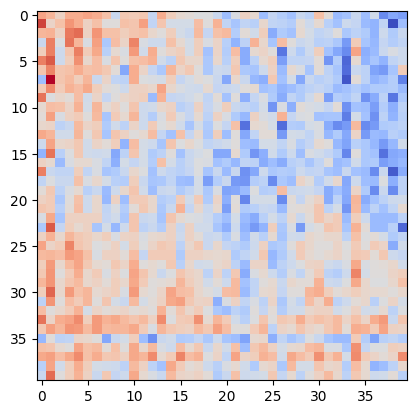

In [ ]:
plt.imshow(np.array(lst)[2000:2040,2000:2040], cmap = 'coolwarm')

In [ ]:
import contextily as cx

In [ ]:
ireland = cx.Place("Barcelona") #, source=nightlights)

<AxesSubplot:title={'center':'Barcelona, Barcelonès, Barcelona, Catalunya, 08001, España'}, xlabel='X', ylabel='Y'>

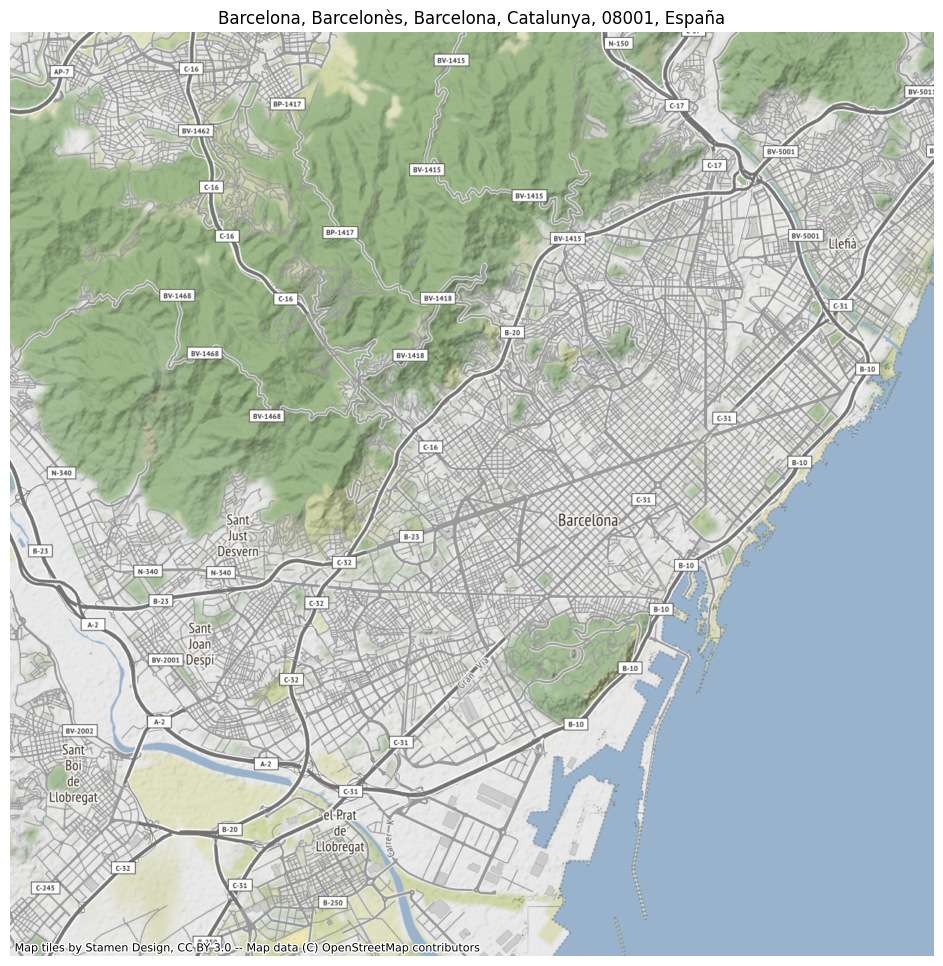

In [ ]:
ireland.plot()

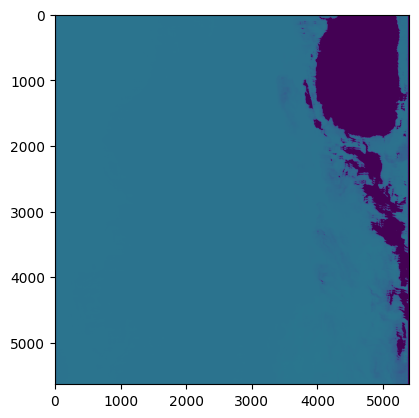

In [ ]:
plt.imshow(lst)

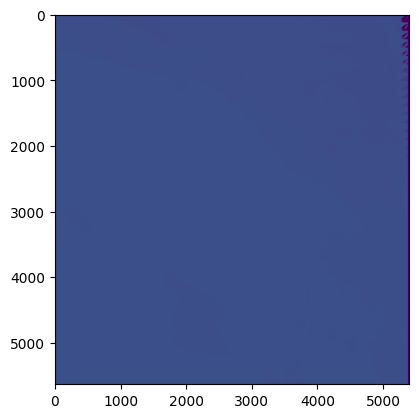

In [ ]:
plt.imshow(lst2)